In [37]:
# Konfiguracja kluczy API (opcjonalne)
# Projekt działa lokalnie bez kluczy (CLIP). 
# Jeśli masz klucze, ustaw je jako zmienne środowiskowe.

import os

# Przykładowe ustawienia (odkomentuj i uzupełnij):
# os.environ["OPENAI_API_KEY"] = "sk-..."           # Płatne
# os.environ["GOOGLE_API_KEY"] = "..."              # Darmowe (limit miesięczny)
# os.environ["HUGGINGFACEHUB_API_TOKEN"] = "hf_..." # Darmowe

# Podgląd ustawień
print("=" * 60)
print("STATUS KLUCZY API")
print("=" * 60)

keys = {
    "OPENAI_API_KEY": ("Płatne", "OpenAI Vision"),
    "GOOGLE_API_KEY": ("Darmowe", "Google Vision"),
    "HUGGINGFACEHUB_API_TOKEN": ("Darmowe", "Hugging Face")
}

any_key = False
for key, (cost, desc) in keys.items():
    value = os.getenv(key)
    if value:
        print(f"✓ {key}: ustawiony ({cost})")
        any_key = True
    else:
        print(f"✗ {key}: brak ({cost})")

print("-" * 60)
if any_key:
    print("Metoda: API (zewnętrzne)")
else:
    print("Metoda: CLIP (offline)")
    print("→ Działa bez kluczy API")
print("=" * 60)

STATUS KLUCZY API
✗ OPENAI_API_KEY: brak (Płatne)
✗ GOOGLE_API_KEY: brak (Darmowe)
✗ HUGGINGFACEHUB_API_TOKEN: brak (Darmowe)
------------------------------------------------------------
Metoda: CLIP (offline)
→ Działa bez kluczy API


In [38]:
# Instalacja pakietów (uruchom raz)
%pip install -q sentence-transformers transformers pillow sqlalchemy torch numpy pandas requests

Note: you may need to restart the kernel to use updated packages.


In [39]:
# Test GPU - weryfikacja działania
import torch

print("=" * 70)
print("🧪 TEST WYKORZYSTANIA GPU")
print("=" * 70)

if torch.cuda.is_available():
    # Test obliczeń na GPU
    x = torch.randn(1000, 1000, device='cuda')
    y = torch.randn(1000, 1000, device='cuda')
    
    # Mnożenie macierzy na GPU
    torch.cuda.synchronize()
    import time
    start = time.time()
    z = torch.mm(x, y)
    torch.cuda.synchronize()
    gpu_time = time.time() - start
    
    print(f"✓ Test obliczeniowy GPU: {gpu_time*1000:.2f} ms")
    print(f"✓ Tensor na GPU: {z.device}")
    print(f"✓ Pamięć zajęta: {torch.cuda.memory_allocated(0) / 1024**2:.1f} MB")
    print(f"✓ Maksymalna pamięć: {torch.cuda.max_memory_allocated(0) / 1024**2:.1f} MB")
    print("✅ GPU działa poprawnie!")
else:
    print(f"⚠ GPU niedostępne - używany CPU")
    print(f"PyTorch wersja: {torch.__version__}")
    
    # Sprawdź typ karty graficznej
    import subprocess
    try:
        result = subprocess.run(['wmic', 'path', 'win32_VideoController', 'get', 'name'], 
                              capture_output=True, text=True, timeout=5)
        gpu_name = [line.strip() for line in result.stdout.split('\n') if line.strip() and line.strip() != 'Name']
        if gpu_name:
            print(f"Wykryta karta: {gpu_name[0]}")
            
            if 'Intel' in gpu_name[0] or 'AMD' in gpu_name[0]:
                print("")
                print("ℹ️  UWAGA: Wykryto kartę Intel/AMD")
                print("   CUDA działa tylko z kartami NVIDIA (GeForce, RTX, GTX)")
                print("")
                print("   ✅ Projekt działa poprawnie na CPU - tylko wolniej")
                print("   📖 Zobacz INFO_GPU.md dla więcej informacji")
            elif 'NVIDIA' in gpu_name[0]:
                print("")
                print("⚠️  Wykryto kartę NVIDIA, ale CUDA nie działa!")
                print("   Zainstaluj sterowniki: https://www.nvidia.com/drivers")
                print("   Zainstaluj CUDA Toolkit: https://developer.nvidia.com/cuda-downloads")
    except:
        pass
    
    print("")
    print("💡 Projekt będzie działać na CPU (wolniej, ale poprawnie)")

print("=" * 70)

🧪 TEST WYKORZYSTANIA GPU
✓ Test obliczeniowy GPU: 1.14 ms
✓ Tensor na GPU: cuda:0
✓ Pamięć zajęta: 38763.7 MB
✓ Maksymalna pamięć: 41011.9 MB
✅ GPU działa poprawnie!


In [40]:
# === GLOBALNE DANE FORMULARZA ===
# Śledzenie stanu wypełnienia ankiety i przesłanych danych

FORM_DATA = {
    'form_complete': False,           # Czy formularz został wypełniony
    'last_uploaded_image': None,      # Ścieżka ostatnio przesłanego obrazu
    'last_part_info': None,           # MetalPart ostatnio przesłanej części
    'auto_run_tests': True            # Czy automatycznie uruchamiać testy po formularzu
}

def require_form_complete():
    """
    Wymaga wypełnienia formularza przed wykonaniem komórki.
    Użyj w komórkach testowych, które potrzebują danych z formularza.
    """
    if not FORM_DATA['form_complete']:
        raise RuntimeError(
            "❌ WYMAGANA ANKIETA!\n\n"
            "Przed uruchomieniem tej komórki musisz:\n"
            "1. Przejść do komórki z formularzem 'Dodaj nową część metalową'\n"
            "2. Wybrać zdjęcie części metalowej\n"
            "3. Wpisać nazwę\n"
            "4. Kliknąć 'Zapisz i klasyfikuj'\n\n"
            "Dopiero po wypełnieniu formularza możesz uruchomić tę komórkę."
        )
    
    if not FORM_DATA['last_uploaded_image']:
        raise RuntimeError(
            "❌ BRAK PRZESŁANEGO OBRAZU!\n\n"
            "Formularz został oznaczony jako wypełniony, ale brak obrazu.\n"
            "Proszę ponownie wypełnić formularz."
        )
    
    print("✅ Formularz wypełniony - kontynuuję...")
    print(f"📷 Używam obrazu: {FORM_DATA['last_uploaded_image']}")
    if FORM_DATA['last_part_info']:
        print(f"📝 Część: {FORM_DATA['last_part_info'].description}")
    print()


def save_verification_to_db(image_path: str, part_id: str, claim: str, 
                            verdict: str, confidence: float, reason: str,
                            test_type: str = "single"):
    """
    Zapisz wynik weryfikacji Qwen do bazy danych.
    
    Args:
        image_path: Ścieżka do obrazu
        part_id: ID części (opcjonalne)
        claim: Testowane twierdzenie
        verdict: Wynik (yes/no/unsure)
        confidence: Pewność (0-1)
        reason: Uzasadnienie
        test_type: Typ testu (single, batch, rag_integration)
    """
    try:
        with SessionLocal() as db:
            log = VerificationLog(
                image_path=str(image_path),
                part_id=part_id,
                claim=claim,
                verdict=verdict,
                confidence=confidence,
                reason=reason,
                test_type=test_type,
                timestamp=datetime.now().isoformat()
            )
            db.add(log)
            db.commit()
            print(f"💾 Zapisano wynik weryfikacji do bazy (ID: {log.id})")
            return log.id
    except Exception as e:
        print(f"⚠️ Błąd zapisu do bazy: {e}")
        return None


def run_qwen_tests_automatically():
    """
    Automatycznie uruchamia testy Qwen po wypełnieniu formularza.
    Zapisuje wszystkie wyniki do bazy danych.
    """
    import time
    
    print()
    print("="*70)
    print("🚀 AUTOMATYCZNE URUCHAMIANIE TESTÓW QWEN")
    print("="*70)
    print()
    
    test_image = FORM_DATA['last_uploaded_image']
    part_info = FORM_DATA['last_part_info']
    
    if not test_image or not part_info:
        print("❌ Brak danych z formularza!")
        return
    
    try:
        # Sprawdź czy verifier jest dostępny
        from qwen_image_verifier import QwenImageVerifier
        import torch
        
        verifier_auto = globals().get('verifier', None)
        if verifier_auto is None:
            print('🔄 Ładowanie Qwen2-VL-7B-Instruct...')
            verifier_auto = QwenImageVerifier(
                model_id="Qwen/Qwen2-VL-7B-Instruct",
                device="cuda" if torch.cuda.is_available() else "cpu"
            )
            globals()['verifier'] = verifier_auto
            print('✅ Model Qwen załadowany!')
        else:
            print('✅ Model Qwen już załadowany')
        
        # ===== TEST 1: Weryfikacja pojedyncza =====
        print("\n" + "="*70)
        print("▶️  TEST 1/3: Weryfikacja wysłanego obrazu")
        print("="*70)
        
        claim1 = f"{part_info.description} - {part_info.material} - kategoria: {part_info.category}"
        print(f"📷 Obraz: {test_image}")
        print(f"📝 Claim: {claim1}")
        
        result1 = verifier_auto.verify(
            image_path=test_image,
            claim=claim1,
            max_new_tokens=256,
            temperature=0.1
        )
        
        print(f"\n📊 WYNIK:")
        print(f"   Verdict: {result1.verdict.upper()}")
        print(f"   Confidence: {result1.confidence:.1%}")
        print(f"   Reason: {result1.reason}")
        
        # Zapisz do bazy
        save_verification_to_db(
            image_path=test_image,
            part_id=part_info.part_id,
            claim=claim1,
            verdict=result1.verdict,
            confidence=result1.confidence,
            reason=result1.reason,
            test_type="single_auto"
        )
        
        # Wyświetl obraz
        from PIL import Image
        import matplotlib.pyplot as plt
        
        img = Image.open(test_image)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Verdict: {result1.verdict.upper()} ({result1.confidence:.0%})")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        time.sleep(1)
        
        # ===== TEST 2: Weryfikacja z różnymi claimami =====
        print("\n" + "="*70)
        print("▶️  TEST 2/3: Weryfikacja z różnymi claimami")
        print("="*70)
        print(f"📷 Testowany obraz: {test_image}")
        
        test_cases = [
            {"claim": f"{part_info.description} - {part_info.material}", "expected": "yes"},
            {"claim": "Część metalowa z przemysłu", "expected": "yes"},
            {"claim": "Przedmiot plastikowy", "expected": "no"},
            {"claim": f"Kategoria: {part_info.category}", "expected": "yes"}
        ]
        
        results_summary = []
        
        for i, test in enumerate(test_cases, 1):
            print(f"\n[{i}/{len(test_cases)}] Claim: {test['claim']}")
            
            result = verifier_auto.verify(
                image_path=test_image,
                claim=test['claim'],
                max_new_tokens=200,
                temperature=0.1
            )
            
            emoji_map = {"yes": "✅", "no": "❌", "unsure": "⚠️"}
            emoji = emoji_map.get(result.verdict, "❓")
            
            print(f"    {emoji} {result.verdict.upper()} ({result.confidence:.0%})")
            print(f"    💭 {result.reason}")
            
            # Zapisz każdy wynik do bazy
            save_verification_to_db(
                image_path=test_image,
                part_id=part_info.part_id,
                claim=test['claim'],
                verdict=result.verdict,
                confidence=result.confidence,
                reason=result.reason,
                test_type="batch_auto"
            )
            
            results_summary.append({
                "claim": test['claim'],
                "verdict": result.verdict,
                "confidence": result.confidence,
                "reason": result.reason,
                "expected": test['expected']
            })
        
        # Podsumowanie w tabeli
        print("\n" + "="*70)
        print("📊 PODSUMOWANIE TESTÓW BATCH")
        print("="*70)
        
        import pandas as pd
        df = pd.DataFrame(results_summary)
        df['confidence_pct'] = df['confidence'].apply(lambda x: f"{x:.0%}")
        print(df[['claim', 'verdict', 'confidence_pct', 'expected']].to_string(index=False))
        
        time.sleep(1)
        
        # ===== TEST 3: Wyszukiwanie podobnych części =====
        print("\n" + "="*70)
        print("▶️  TEST 3/3: Wyszukiwanie podobnych części w bazie")
        print("="*70)
        
        with SessionLocal() as db:
            similar_results = search_parts_by_image(
                db,
                image_path=test_image,
                top_k=5
            )
            
            if similar_results:
                print(f"\n📊 Znaleziono {len(similar_results)} podobnych części:\n")
                for idx, (part, score) in enumerate(similar_results, 1):
                    print(f"  #{idx}: {part.description} [{part.part_id}]")
                    print(f"       Kategoria: {part.category}, Materiał: {part.material}")
                    print(f"       Similarity: {score:.4f}")
                    if part.image_path:
                        print(f"       Obraz: {part.image_path}")
                    print()
                    
                    # Zapisz log wyszukiwania podobnych
                    save_verification_to_db(
                        image_path=test_image,
                        part_id=part.part_id,
                        claim=f"Podobieństwo do {part_info.description}",
                        verdict="similar",
                        confidence=float(score),
                        reason=f"Znaleziono podobną część: {part.description}",
                        test_type="similarity_search"
                    )
            else:
                print("⚠️ Brak podobnych części w bazie")
        
        print("\n" + "="*70)
        print("✅ WSZYSTKIE AUTOMATYCZNE TESTY UKOŃCZONE!")
        print("="*70)
        
        # Pokaż statystyki weryfikacji
        with SessionLocal() as db:
            total_verifications = db.query(VerificationLog).count()
            print(f"\n📈 Łączna liczba weryfikacji w bazie: {total_verifications}")
        
    except Exception as e:
        print(f"\n❌ Błąd podczas automatycznego uruchamiania: {e}")
        print("   Uruchom następne komórki ręcznie.")
        import traceback
        traceback.print_exc()


def set_form_complete(image_path: str, part_info):
    """
    Oznacz formularz jako wypełniony po pomyślnym przesłaniu obrazu.
    Używane wewnątrz formularza po klasyfikacji.
    Automatycznie uruchamia testy Qwen jeśli auto_run_tests=True.
    """
    FORM_DATA['form_complete'] = True
    FORM_DATA['last_uploaded_image'] = image_path
    FORM_DATA['last_part_info'] = part_info
    
    print()
    print("="*60)
    print("✅ FORMULARZ WYPEŁNIONY!")
    print("="*60)
    print(f"📷 Obraz: {image_path}")
    print(f"📝 Część: {part_info.description}")
    print("="*60)
    
    # Automatyczne uruchamianie testów z zapisem do bazy
    if FORM_DATA.get('auto_run_tests', True):
        run_qwen_tests_automatically()
    else:
        print()
        print("ℹ️  Uruchom następne komórki testowe ręcznie.")


def reset_form():
    """Zresetuj stan formularza (opcjonalne)."""
    FORM_DATA['form_complete'] = False
    FORM_DATA['last_uploaded_image'] = None
    FORM_DATA['last_part_info'] = None
    print("🔄 Formularz zresetowany - wymagane ponowne wypełnienie")


def get_verification_stats():
    """Pokaż statystyki weryfikacji z bazy danych."""
    with SessionLocal() as db:
        total = db.query(VerificationLog).count()
        by_verdict = {}
        by_type = {}
        
        for log in db.query(VerificationLog).all():
            verdict = log.verdict or "unknown"
            by_verdict[verdict] = by_verdict.get(verdict, 0) + 1
            
            test_type = log.test_type or "unknown"
            by_type[test_type] = by_type.get(test_type, 0) + 1
        
        print("\n" + "="*60)
        print("📊 STATYSTYKI WERYFIKACJI OBRAZÓW")
        print("="*60)
        print(f"\nŁączna liczba weryfikacji: {total}")
        
        print("\nPo wyniku (verdict):")
        for verdict, count in sorted(by_verdict.items()):
            emoji = {"yes": "✅", "no": "❌", "unsure": "⚠️", "similar": "🔍"}.get(verdict, "❓")
            print(f"  {emoji} {verdict}: {count}")
        
        print("\nPo typie testu:")
        for test_type, count in sorted(by_type.items()):
            print(f"  • {test_type}: {count}")
        
        print("="*60)


print("✅ System śledzenia formularza zainicjalizowany")
print(f"   Status: {'Wypełniony' if FORM_DATA['form_complete'] else 'Nie wypełniony'}")
print(f"   Auto-run: {'Włączony' if FORM_DATA.get('auto_run_tests', True) else 'Wyłączony'}")

✅ System śledzenia formularza zainicjalizowany
   Status: Nie wypełniony
   Auto-run: Włączony


# RAG do wyszukiwania części metalowych

System rozpoznaje części na obrazach i zapisuje wyniki do SQLite. Może używać zewnętrznych API, ale działa też w pełni offline.

## API (opcjonalnie)
- OpenAI Vision (płatne)
- Google Vision (darmowe limity)
- Hugging Face (captioning)

## Baza danych
- SQLite: metal_parts.db
- Tabele: metal_parts, search_logs
- Pola: part_id, description, material, category, dimensions, tags, image_path, embeddings, created_at

## Jak używać
1. (Opcjonalnie) ustaw klucz do jednego z API.
2. Uruchom komórki 1–7 (inicjalizacja).
3. Uruchom komórkę 17, aby przetworzyć obrazy z obrazy/metal/.
4. Wyniki trafią do bazy.

## Przykład rekordu
{
  "part_id": "BEA-M1",
  "description": "Bearing",
  "material": "Stal chromowana",
  "category": "bearings",
  "dimensions": {"source": "openai_vision_api", "raw_info": "..."},
  "tags": ["metal", "part", "bearings", "api_recognized"],
  "image_path": "obrazy/metal/m1.jpg",
  "created_at": "2025-12-29T..."
}

## 1. Inicjalizacja i Konfiguracja

In [41]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["USE_TF"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import torch
import numpy as np
from pathlib import Path
from typing import List, Optional, Dict
from dataclasses import dataclass
from datetime import datetime

from sqlalchemy import create_engine, Column, Integer, String, Float, JSON, ForeignKey
from sqlalchemy.orm import declarative_base, sessionmaker, Session, relationship
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
import requests

# config - ZAKTUALIZOWANE MODELE (darmowe, lepsze)
EMBEDDING_MODEL = "sentence-transformers/clip-ViT-L-14"  # Większy CLIP (428M vs 151M)
LLM_MODEL = "microsoft/Phi-3-mini-4k-instruct"  # Phi-3 3.8B (vs TinyLlama 1.1B)
DATABASE_URL = "sqlite:///metal_parts.db"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Diagnostyka GPU
print("=" * 70)
print("🔧 DIAGNOSTYKA SPRZĘTU")
print("=" * 70)
print(f"✓ PyTorch: {torch.__version__}")
print(f"✓ CUDA dostępne: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ CUDA: {torch.version.cuda}")
    print(f"✓ Pamięć GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"✓ Urządzenie obliczeniowe: GPU ({DEVICE})")
else:
    print(f"⚠ Urządzenie obliczeniowe: CPU (wolniejsze)")
print("=" * 70)
print(f"📊 Model embeddingów: {EMBEDDING_MODEL}")
print(f"🤖 Model LLM: {LLM_MODEL}")
print(f"💾 Baza danych: {DATABASE_URL}")
print("=" * 70)

# baza danych
Base = declarative_base()

engine = create_engine(DATABASE_URL, echo=False)
SessionLocal = sessionmaker(bind=engine)

🔧 DIAGNOSTYKA SPRZĘTU
✓ PyTorch: 2.9.0+cu130
✓ CUDA dostępne: True
✓ GPU: NVIDIA GB10
✓ CUDA: 13.0
✓ Pamięć GPU: 119.6 GB
✓ Urządzenie obliczeniowe: GPU (cuda)
📊 Model embeddingów: sentence-transformers/clip-ViT-L-14
🤖 Model LLM: microsoft/Phi-3-mini-4k-instruct
💾 Baza danych: sqlite:///metal_parts.db


## 2. Modele Danych

In [42]:
from dataclasses import dataclass
from typing import List, Optional, Dict

@dataclass
class MetalPart:
    """Model części metalowej."""
    part_id: str
    description: str
    material: str
    category: str
    dimensions: Dict
    tags: List[str]
    image_path: Optional[str] = None
    image_embedding: Optional[List[float]] = None
    text_embedding: Optional[List[float]] = None


class PartDB(Base):
    """Tabela: metal_parts."""
    __tablename__ = "metal_parts"

    id = Column(Integer, primary_key=True, autoincrement=True)
    part_id = Column(String, unique=True, nullable=False)
    description = Column(String, nullable=False)
    material = Column(String, nullable=True)
    category = Column(String, nullable=True)
    dimensions = Column(JSON, nullable=True)
    tags = Column(JSON, nullable=True)
    image_path = Column(String, nullable=True)
    image_embedding = Column(String, nullable=True)
    text_embedding = Column(String, nullable=True)
    created_at = Column(String, nullable=True)


class SearchLog(Base):
    """Tabela: search_logs."""
    __tablename__ = "search_logs"

    id = Column(Integer, primary_key=True, autoincrement=True)
    query = Column(String, nullable=False)
    query_type = Column(String, nullable=False)
    top_k = Column(Integer, nullable=True)
    results_count = Column(Integer, nullable=True)
    timestamp = Column(String, nullable=True)


class VerificationLog(Base):
    """Tabela: verification_logs - logi weryfikacji obrazów przez Qwen."""
    __tablename__ = "verification_logs"

    id = Column(Integer, primary_key=True, autoincrement=True)
    image_path = Column(String, nullable=False)
    part_id = Column(String, nullable=True)
    claim = Column(String, nullable=False)
    verdict = Column(String, nullable=False)  # yes, no, unsure
    confidence = Column(Float, nullable=True)
    reason = Column(String, nullable=True)
    test_type = Column(String, nullable=True)  # single, batch, rag_integration
    timestamp = Column(String, nullable=True)


def init_database():
    """Tworzy tabele."""
    Base.metadata.create_all(engine)
    print("✓ Baza danych zainicjalizowana")

init_database()

✓ Baza danych zainicjalizowana


## 3. Embeddingi i Ekstrakcja Cech

In [43]:
# Embeddingi
print("Ładowanie modelu embeddingów...")
embedding_model = SentenceTransformer(EMBEDDING_MODEL, device=DEVICE)
print(f"✓ Model embeddingów: {EMBEDDING_MODEL}")

def get_text_embedding(text: str) -> List[float]:
    """Tekst → embedding."""
    embedding = embedding_model.encode(text, normalize_embeddings=True)
    return embedding.tolist()


def get_image_embedding(image_path: str) -> List[float]:
    """Obraz → embedding."""
    from PIL import Image
    try:
        img = Image.open(image_path).convert('RGB')
        img_embedding = embedding_model.encode(img, normalize_embeddings=True)
        return img_embedding.tolist()
    except Exception as e:
        print(f"✗ Błąd wczytywania obrazu {image_path}: {e}")
        return None


def build_part_text(part: MetalPart) -> str:
    """Krótki opis części do embeddingu."""
    dims_str = ", ".join([f"{k}: {v}" for k, v in (part.dimensions or {}).items()])
    tags_str = ", ".join(part.tags)

    text = f"""
    Część metalowa: {part.description}
    ID: {part.part_id}
    Kategoria: {part.category}
    Materiał: {part.material}
    Wymiary: {dims_str}
    Tagi: {tags_str}
    """
    return text


# Szybki test
test_text = "Śruba sześciokątna M8 ze stali nierdzewnej"
test_emb = get_text_embedding(test_text)
print(f"\n✓ Test embeddingu tekstowego:")
print(f"  Tekst: {test_text}")
print(f"  Długość embeddingu: {len(test_emb)}D")
print(f"  Pierwsze 5 wartości: {test_emb[:5]}")

Ładowanie modelu embeddingów...
✓ Model embeddingów: sentence-transformers/clip-ViT-L-14

✓ Test embeddingu tekstowego:
  Tekst: Śruba sześciokątna M8 ze stali nierdzewnej
  Długość embeddingu: 768D
  Pierwsze 5 wartości: [0.0020341789349913597, 0.01766081154346466, -0.024842265993356705, 0.022097237408161163, -0.018095938488841057]


## 4. Funkcje do Indeksowania Części

In [44]:
def add_part_to_db(db: Session, part: MetalPart) -> bool:
    """Dodaje część do bazy."""
    try:
        text_desc = build_part_text(part)
        text_emb = get_text_embedding(text_desc)

        image_emb = None
        if part.image_path and Path(part.image_path).exists():
            image_emb = get_image_embedding(part.image_path)

        text_emb_str = ";".join(str(x) for x in text_emb) if text_emb else None
        image_emb_str = ";".join(str(x) for x in image_emb) if image_emb else None

        db_part = PartDB(
            part_id=part.part_id,
            description=part.description,
            material=part.material,
            category=part.category,
            dimensions=part.dimensions,
            tags=part.tags,
            image_path=part.image_path,
            text_embedding=text_emb_str,
            image_embedding=image_emb_str,
            created_at=datetime.now().isoformat()
        )
        db.add(db_part)
        db.commit()
        return True
    except Exception as e:
        print(f"✗ Błąd dodawania części: {e}")
        return False


def load_parts_from_db(db: Session) -> List[PartDB]:
    """Zwraca wszystkie części."""
    return db.query(PartDB).all()


def parse_embedding_from_db(emb_str: str) -> List[float]:
    """Konwersja string → lista float."""
    if not emb_str:
        return None
    return [float(x) for x in emb_str.split(";")]


def cosine_similarity(a: List[float], b: List[float]) -> float:
    """Podobieństwo kosinusowe."""
    a = np.array(a)
    b = np.array(b)
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)

print("✓ Funkcje indeksowania załadowane")

✓ Funkcje indeksowania załadowane


## 5. Retriever - Wyszukiwanie Podobnych Części

In [45]:
def search_parts_by_text(db: Session, query: str, top_k: int = 5, category_filter: Optional[str] = None) -> List[tuple]:
    """Wyszukiwanie po tekście."""
    query_emb = get_text_embedding(query)
    all_parts = load_parts_from_db(db)

    results = []
    for part in all_parts:
        if category_filter and part.category != category_filter:
            continue

        part_emb = parse_embedding_from_db(part.image_embedding)
        if not part_emb:
            continue

        score = cosine_similarity(query_emb, part_emb)
        results.append((part, score))

    results.sort(key=lambda x: x[1], reverse=True)
    return results[:top_k]


def search_parts_by_image(db: Session, image_path: str, top_k: int = 5, category_filter: Optional[str] = None) -> List[tuple]:
    """Wyszukiwanie po obrazie."""
    query_emb = get_image_embedding(image_path)
    if not query_emb:
        return []

    all_parts = load_parts_from_db(db)

    results = []
    for part in all_parts:
        if category_filter and part.category != category_filter:
            continue

        part_emb = parse_embedding_from_db(part.image_embedding)
        if not part_emb:
            continue

        score = cosine_similarity(query_emb, part_emb)
        results.append((part, score))

    results.sort(key=lambda x: x[1], reverse=True)
    return results[:top_k]


def search_parts_hybrid(db: Session, text_query: str, image_path: Optional[str] = None,
                       top_k: int = 5, category_filter: Optional[str] = None) -> List[tuple]:
    """Hybryda: tekst + obraz."""
    text_results = search_parts_by_text(db, text_query, top_k=top_k*2, category_filter=category_filter)

    if image_path and Path(image_path).exists():
        image_results = search_parts_by_image(db, image_path, top_k=top_k*2, category_filter=category_filter)

        combined = {}
        for part, score in text_results:
            combined[part.id] = {"part": part, "score": score * 0.7}

        for part, score in image_results:
            if part.id in combined:
                combined[part.id]["score"] += score * 0.3
            else:
                combined[part.id] = {"part": part, "score": score * 0.3}

        results = [(v["part"], v["score"]) for v in combined.values()]
    else:
        results = text_results

    results.sort(key=lambda x: x[1], reverse=True)
    return results[:top_k]

print("✓ Retriever załadowany")

✓ Retriever załadowany


## 6. LLM - Generacja Raportu

In [46]:
# Model LLM
print("Ładowanie modelu LLM...")
try:
    tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL)
    
    # Optymalizacja GPU: FP16 + device_map
    if DEVICE == "cuda":
        llm_model = AutoModelForCausalLM.from_pretrained(
            LLM_MODEL, 
            torch_dtype=torch.float16,
            device_map="auto",
            low_cpu_mem_usage=True
        )
        print(f"✓ LLM załadowany na GPU z FP16")
    else:
        llm_model = AutoModelForCausalLM.from_pretrained(LLM_MODEL, low_cpu_mem_usage=True)
        llm_model = llm_model.to(DEVICE)
        print(f"✓ LLM załadowany na CPU")
    
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    print(f"✓ Model: {LLM_MODEL}")
except Exception as e:
    print(f"✗ Błąd ładowania LLM: {e}")
    llm_model = None
    tokenizer = None


def generate_report(results: List[tuple], query: str) -> str:
    """Raport na podstawie wyników."""
    if not llm_model or not tokenizer:
        return generate_simple_report(results, query)

    context = "\n\n".join([
        f"Część {i+1}:\n"
        f"  ID: {part.part_id}\n"
        f"  Opis: {part.description}\n"
        f"  Materiał: {part.material}\n"
        f"  Kategoria: {part.category}\n"
        f"  Wymiary: {part.dimensions}\n"
        f"  Tagi: {', '.join(part.tags or [])}\n"
        f"  Dopasowanie: {score*100:.1f}%"
        for i, (part, score) in enumerate(results)
    ])

    prompt = f"""
    Zapytanie użytkownika: "{query}"

    Wyniki:
    {context}

    Proszę o krótki, konkretny raport.
    """

    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(DEVICE)

    with torch.no_grad():
        outputs = llm_model.generate(
            **inputs,
            max_new_tokens=256,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.split("Wyniki:")[-1].strip() if "Wyniki:" in response else response


def generate_simple_report(results: List[tuple], query: str) -> str:
    """Prosty tekstowy raport."""
    report = f"RAPORT WYSZUKIWANIA\n"
    report += f"Zapytanie: {query}\n"
    report += f"Znaleziono: {len(results)} części\n"
    report += "\n" + "="*60 + "\n\n"

    for i, (part, score) in enumerate(results, 1):
        report += f"#{i} (Dopasowanie: {score*100:.1f}%)\n"
        report += f"  ID: {part.part_id}\n"
        report += f"  Opis: {part.description}\n"
        report += f"  Materiał: {part.material}\n"
        report += f"  Kategoria: {part.category}\n"
        if part.dimensions:
            report += f"  Wymiary: {part.dimensions}\n"
        if part.tags:
            report += f"  Tagi: {', '.join(part.tags)}\n"
        report += "\n"

    return report

print("✓ Funkcje raportu załadowane")

Ładowanie modelu LLM...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


✓ LLM załadowany na GPU z FP16
✓ Model: microsoft/Phi-3-mini-4k-instruct
✓ Funkcje raportu załadowane


## 7. Główna Funkcja RAG

In [47]:
def rag_search_metal_parts(query: str, query_type: str = "text", image_path: Optional[str] = None,
                          category_filter: Optional[str] = None, top_k: int = 5) -> Dict:
    """Główna funkcja RAG."""
    with SessionLocal() as db:
        if query_type == "text":
            results = search_parts_by_text(db, query, top_k=top_k, category_filter=category_filter)
        elif query_type == "image":
            if not image_path:
                return {"error": "Brak ścieżki do obrazu dla query_type='image'."}
            results = search_parts_by_image(db, image_path, top_k=top_k, category_filter=category_filter)
        elif query_type == "hybrid":
            if not image_path:
                return {"error": "Brak ścieżki do obrazu dla query_type='hybrid'."}
            results = search_parts_hybrid(db, query, image_path=image_path, top_k=top_k, category_filter=category_filter)
        else:
            return {"error": f"Nieznany typ wyszukiwania: {query_type}"}

        results_dicts = [
            ({
                "id": part.id,
                "part_id": part.part_id,
                "description": part.description,
                "material": part.material,
                "category": part.category,
                "dimensions": part.dimensions,
                "tags": part.tags,
                "image_path": part.image_path,
                "created_at": part.created_at,
                "similarity_score": float(score),
            }, score)
            for part, score in results
        ]

        report = generate_simple_report(results, query)

        log = SearchLog(
            query=query,
            query_type=query_type,
            top_k=top_k,
            results_count=len(results),
            timestamp=datetime.now().isoformat(),
        )
        db.add(log)
        db.commit()

        return {
            "query": query,
            "query_type": query_type,
            "results": results_dicts,
            "report": report,
            "timestamp": datetime.now().isoformat(),
        }


def display_search_results(results_data: Dict) -> None:
    """Czytelny wydruk wyników."""
    print(f"\n{'='*90}")
    print("WYNIKI WYSZUKIWANIA")
    print(f"{'='*90}")
    print(f"Query: {results_data.get('query', 'N/A')}")
    print(f"Typ: {results_data.get('query_type', 'N/A')}")
    print(f"Timestamp: {results_data.get('timestamp', 'N/A')}")
    print(f"Znaleziono: {len(results_data.get('results', []))} części\n")

    rows = results_data.get('results', [])
    if not rows:
        print("⚠ Brak wyników")
        return

    print(f"{'#':<3} | {'ID':<15} | {'Opis':<35} | {'Materiał':<20} | {'Kategoria':<15} | {'Score':<8}")
    print(f"{'-'*3}-+-{'-'*15}-+-{'-'*35}-+-{'-'*20}-+-{'-'*15}-+-{'-'*8}")

    for i, (part_dict, score) in enumerate(rows, 1):
        part_id = (part_dict.get('part_id') or 'N/A')[:15]
        description = (part_dict.get('description') or 'N/A')[:35]
        material = (part_dict.get('material') or 'N/A')[:20]
        category = (part_dict.get('category') or 'N/A')[:15]
        score_val = f"{score:.4f}"
        print(f"{i:<3} | {part_id:<15} | {description:<35} | {material:<20} | {category:<15} | {score_val:<8}")

    best_match, best_score = rows[0]
    print(f"\n{'='*90}")
    print("NAJLEPSZE DOPASOWANIE:")
    print(f"{'='*90}")
    print(f"ID bazy:         {best_match.get('id', 'N/A')}")
    print(f"Part ID:         {best_match.get('part_id', 'N/A')}")
    print(f"Opis:            {best_match.get('description', 'N/A')}")
    print(f"Materiał:        {best_match.get('material', 'N/A')}")
    print(f"Kategoria:       {best_match.get('category', 'N/A')}")
    print(f"Wymiary:         {best_match.get('dimensions', {})}")
    tags_val = best_match.get('tags') or []
    print(f"Tagi:            {', '.join(tags_val) if tags_val else ''}")
    print(f"Ścieżka obrazu:  {best_match.get('image_path', 'N/A')}")
    print(f"Utworzono:       {best_match.get('created_at', 'N/A')}")
    print(f"Similarity:      {best_score:.4f}")
    print(f"{'='*90}\n")

## 8. Przykładowe Dane i Test

In [48]:
# Klasyfikacja obrazów części metalowych
import os
import requests
import json
import base64
from pathlib import Path
from PIL import Image

# Konfiguracja API
HF_API_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

# Podpisy obrazów (Hugging Face)
HF_CAPTION_ENDPOINT = "https://api-inference.huggingface.co/models/Salesforce/blip2-opt-2.7b"


def analyze_image_with_openai(image_path: str) -> Optional[Dict]:
    """Analiza przez OpenAI Vision."""
    if not OPENAI_API_KEY:
        return None
    
    try:
        with open(image_path, "rb") as f:
            image_data = base64.b64encode(f.read()).decode('utf-8')
        
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {OPENAI_API_KEY}"
        }
        
        payload = {
            "model": "gpt-4o-mini",
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": """Analyze this metal part image and provide:
1. Part name (e.g., "Bearing", "Bolt", "Screw", "Nut", "Washer")
2. Material (e.g., "Stal chromowana", "Aluminium", "Stal nierdzewna")
3. Category (e.g., "bearings", "fasteners", "bolts", "nuts")
4. Estimated dimensions if visible
5. Any visible markings or specifications

Respond in JSON format:
{
    "part_name": "string",
    "material": "string", 
    "category": "string",
    "dimensions": "string or null",
    "description": "brief description"
}"""
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{image_data}"
                            }
                        }
                    ]
                }
            ],
            "max_tokens": 500
        }
        
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers=headers,
            json=payload,
            timeout=30
        )
        response.raise_for_status()
        
        result = response.json()
        content = result['choices'][0]['message']['content']
        
        try:
            if "```json" in content:
                json_str = content.split("```json")[1].split("```")[0].strip()
            elif "```" in content:
                json_str = content.split("```")[1].split("```")[0].strip()
            else:
                json_str = content.strip()
            
            data = json.loads(json_str)
            return data
        except:
            return {"description": content}
            
    except Exception as e:
        print(f"⚠ Błąd OpenAI Vision API: {e}")
        return None


def analyze_image_with_google(image_path: str) -> Optional[Dict]:
    """Analiza przez Google Vision."""
    if not GOOGLE_API_KEY:
        return None
    
    try:
        from google.cloud import vision
        import io
        
        client = vision.ImageAnnotatorClient()
        
        with io.open(image_path, 'rb') as image_file:
            content = image_file.read()
        
        image = vision.Image(content=content)
        
        response = client.label_detection(image=image)
        labels = response.label_annotations
        
        text_response = client.text_detection(image=image)
        texts = text_response.text_annotations
        
        result = {
            "labels": [label.description for label in labels[:5]],
            "text": texts[0].description if texts else None,
            "confidence": labels[0].score if labels else 0
        }
        
        return result
        
    except Exception as e:
        print(f"⚠ Błąd Google Vision API: {e}")
        return None


def caption_image_online(image_path: str) -> Optional[str]:
    """Podpis z Hugging Face."""
    if not HF_API_TOKEN:
        return None
    try:
        with open(image_path, "rb") as f:
            img_bytes = f.read()
        headers = {"Authorization": f"Bearer {HF_API_TOKEN}"}
        resp = requests.post(HF_CAPTION_ENDPOINT, headers=headers, data=img_bytes, timeout=25)
        resp.raise_for_status()
        out = resp.json()
        if isinstance(out, list) and out and isinstance(out[0], dict) and "generated_text" in out[0]:
            return out[0]["generated_text"]
    except Exception as e:
        print(f"⚠ Nie udało się pobrać podpisu z HF: {e}")
    return None


def classify_metal_part_from_image(image_path: str) -> Optional[MetalPart]:
    """Klasyfikacja z obrazu (OpenAI > Google > CLIP).""" ### clip?
    try:
        if not Path(image_path).exists():
            print(f"✗ Obraz nie znaleziony: {image_path}")
            return None
        
        img = Image.open(image_path).convert('RGB')
        
        print(f"   🔍 Próba rozpoznania przez OpenAI Vision API...")
        api_result = analyze_image_with_openai(image_path)
        
        if api_result and 'part_name' in api_result:
            print(f"   ✓ OpenAI: {api_result.get('part_name')}")
            
            part_name = api_result.get('part_name', 'Unknown Part')
            material = api_result.get('material', 'Nieznany')
            category = api_result.get('category', 'fasteners')
            description_text = api_result.get('description', part_name)
            dimensions_str = api_result.get('dimensions', '')
            
            img_embedding = embedding_model.encode(img, normalize_embeddings=True)
            part_id = Path(image_path).stem.upper()
            tags = ["metal", "part", category, "api_recognized", image_path]
            if dimensions_str:
                tags.append(f"dim:{dimensions_str}")
            
            dimensions = {
                "source": "openai_vision_api",
                "raw_info": dimensions_str or "not_specified"
            }
            
            part = MetalPart(
                part_id=f"{category.upper()[:3]}-{part_id}",
                description=part_name,
                material=material,
                category=category,
                dimensions=dimensions,
                tags=tags,
                image_path=image_path,
                image_embedding=img_embedding.tolist()
            )
            
            print(f"   ↳ Nazwa: {part_name}")
            print(f"   ↳ Kategoria: {category}")
            print(f"   ↳ Materiał: {material}")
            
            return part
        
        print(f"   🔍 Próba rozpoznania przez Google Vision API...")
        google_result = analyze_image_with_google(image_path)
        
        if google_result and google_result.get('labels'):
            print(f"   ✓ Google Vision: {', '.join(google_result['labels'][:3])}")
        
        print(f"   🔍 Fallback: CLIP embedding...")
        
        caption = caption_image_online(image_path)
        if caption:
            print(f"   ↳ Caption: {caption}")
        
        img_embedding = embedding_model.encode(img, normalize_embeddings=True)
        
        categories = [
            "fasteners", "bearings", "springs", "shafts", "gears",
            "nuts", "bolts", "washers", "plates", "brackets", "pipes",
            "screws", "rivets", "hinges", "clamps"
        ]
        materials = [
            "Stal nierdzewna", "Stal zwykła", "Stal chromowana", "Stal hartowana",
            "Aluminium", "Miedź", "Brąz", "Tytan", "Żeliwo", "Nieznany"
        ]
        
        from scipy.spatial.distance import cosine
        category_embeddings = [embedding_model.encode(f"A {cat} part", normalize_embeddings=True) for cat in categories]
        material_embeddings = [embedding_model.encode(f"Made of {mat}", normalize_embeddings=True) for mat in materials]
        
        category_scores = [1 - cosine(img_embedding, cat_emb) for cat_emb in category_embeddings]
        material_scores = [1 - cosine(img_embedding, mat_emb) for mat_emb in material_embeddings]
        
        best_category = categories[int(np.argmax(category_scores))]
        best_material = materials[int(np.argmax(material_scores))]
        
        category_names = {
            "fasteners": "Fastener", "bearings": "Bearing", "springs": "Spring",
            "shafts": "Shaft", "gears": "Gear", "nuts": "Nut", "bolts": "Bolt",
            "washers": "Washer", "plates": "Plate", "brackets": "Bracket",
            "pipes": "Pipe", "screws": "Screw", "rivets": "Rivet",
            "hinges": "Hinge", "clamps": "Clamp"
        }
        part_name = category_names.get(best_category, best_category.capitalize())
        
        print(f"   ↳ CLIP: {part_name} ({best_category})")
        
        part_id = Path(image_path).stem.upper()
        tags = ["metal", "part", best_category, "clip_classified", image_path]
        
        part = MetalPart(
            part_id=f"{best_category.upper()[:3]}-{part_id}",
            description=part_name,
            material=best_material,
            category=best_category,
            dimensions={"source": "clip_embedding"},
            tags=tags,
            image_path=image_path,
            image_embedding=img_embedding.tolist()
        )
        return part
        
    except Exception as e:
        print(f"✗ Błąd klasyfikacji obrazu {image_path}: {e}")
        import traceback
        traceback.print_exc()
        return None


def classify_parts_from_folder(folder_path: str = "obrazy/metal/") -> List[MetalPart]:
    """Klasyfikacja obrazów z folderu."""
    parts = []
    image_extensions = ['.jpg', '.jpeg', '.png', '.webp', '.bmp']
    
    folder = Path(folder_path)
    if not folder.exists():
        print(f"⚠ Folder nie istnieje: {folder_path}")
        return parts
    
    image_files = []
    for ext in image_extensions:
        image_files.extend(folder.glob(f"*{ext}"))
        image_files.extend(folder.glob(f"*{ext.upper()}"))
    
    if not image_files:
        print(f"⚠ Brak obrazów w folderze: {folder_path}")
        return parts
    
    print(f"\n🔍 Klasyfikowanie {len(image_files)} obrazów z folderu {folder_path}...")
    print(f"📡 API dostępne:")
    print(f"   - OpenAI Vision: {'✓' if OPENAI_API_KEY else '✗'}")
    print(f"   - Google Vision: {'✓' if GOOGLE_API_KEY else '✗'}")
    print(f"   - Hugging Face: {'✓' if HF_API_TOKEN else '✗'}")
    print()
    
    for image_file in sorted(image_files):
        print(f"\n{'='*70}")
        print(f"📷 {image_file.name}")
        print(f"{'='*70}")
        part = classify_metal_part_from_image(str(image_file))
        if part:
            parts.append(part)
            print(f"\n✓ ZAPISANO:")
            print(f"   ID: {part.part_id}")
            print(f"   Nazwa: {part.description}")
            print(f"   Kategoria: {part.category}")
            print(f"   Materiał: {part.material}")
        else:
            print(f"\n✗ Nie udało się sklasyfikować")
    
    print(f"\n{'='*70}")
    print(f"✓ Zaklasyfikowano {len(parts)} z {len(image_files)} obrazów")
    print(f"{'='*70}")
    return parts


def fetch_parts_from_internet() -> List[MetalPart]:
    """Rozpoznawanie przez API lub offline."""
    print("📷 Rozpoznawanie części metalowych przez API...")
    parts_from_images = classify_parts_from_folder("obrazy/metal/")
    if parts_from_images:
        print(f"\n✓ Rozpoznano {len(parts_from_images)} części")
        return parts_from_images
    print("\n⚠ Nie znaleziono obrazów lub rozpoznawanie nie powiodło się")
    return []


# Rozpoznaj wszystkie obrazy
print("\n" + "="*70)
print("ROZPOZNAWANIE CZĘŚCI METALOWYCH PRZEZ API")
print("="*70)
CURRENT_PARTS = fetch_parts_from_internet()

# Dodaj do bazy
with SessionLocal() as db:
    existing = db.query(PartDB).count()
    if existing == 0:
        print(f"\n{'='*70}")
        print(f"DODAWANIE {len(CURRENT_PARTS)} CZĘŚCI DO BAZY DANYCH")
        print(f"{'='*70}\n")
        for part in CURRENT_PARTS:
            success = add_part_to_db(db, part)
            if success:
                print(f"✓ {part.part_id}: {part.description}")
                print(f"  └─ {part.category} | {part.material} | {part.image_path}")
        print(f"\n{'='*70}")
        print(f"✓ {len(CURRENT_PARTS)} części zapisanych w bazie SQLite")
        print(f"{'='*70}\n")
    else:
        print(f"\n✓ Baza zawiera już {existing} części")
        print(f"   Aby ponownie zaindeksować, uruchom komórkę 1 (wyczyść bazę).\n")


ROZPOZNAWANIE CZĘŚCI METALOWYCH PRZEZ API
📷 Rozpoznawanie części metalowych przez API...

🔍 Klasyfikowanie 23 obrazów z folderu obrazy/metal/...
📡 API dostępne:
   - OpenAI Vision: ✗
   - Google Vision: ✗
   - Hugging Face: ✗


📷 m1.jpg
   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Pipe (pipes)

✓ ZAPISANO:
   ID: PIP-M1
   Nazwa: Pipe
   Kategoria: pipes
   Materiał: Tytan

📷 m10.webp
   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Fastener (fasteners)

✓ ZAPISANO:
   ID: FAS-M10
   Nazwa: Fastener
   Kategoria: fasteners
   Materiał: Aluminium

📷 m11.jpg
   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Fastener (fasteners)

✓ ZAPISANO:
   ID: FAS-M11
   Nazwa: Fastener
   Kategoria: fasteners
   Mat

## 9. Testy Wyszukiwania RAG

In [49]:
def add_new_metal_part_from_image(image_path: str) -> bool:
    """Dodaj nową część z obrazu"""
    print(f"\n📷 Klasyfikuję nową część z obrazu: {image_path}")
    
    part = classify_metal_part_from_image(image_path)
    if not part:
        print(f"✗ Nie udało się zaklasyfikować obrazu")
        return False
    
    print(f"\nZaklasyfikowana część:")
    print(f"  ID: {part.part_id}")
    print(f"  Opis: {part.description}")
    print(f"  Kategoria: {part.category}")
    print(f"  Materiał: {part.material}")
    print(f"  Tagi: {', '.join(part.tags)}")
    
    with SessionLocal() as db:
        existing = db.query(PartDB).filter_by(image_path=image_path).first()
        if existing:
            print(f"\n⚠ Część z tego obrazu już istnieje w bazie: {existing.part_id}")
            return False
        
        success = add_part_to_db(db, part)
        if success:
            print(f"\n✓ Część dodana do bazy!")
            return True
        else:
            print(f"\n✗ Błąd podczas dodawania do bazy")
            return False


# test dodawania nowej części
print("\n" + "="*70)
print("TEST: Dodanie Nowej Części z Obrazu")
print("="*70)

test_new_image = "obrazy/metal/m1.jpg"
if Path(test_new_image).exists():
    add_new_metal_part_from_image(test_new_image)
else:
    print(f"⚠ Test image {test_new_image} nie znaleziony")


TEST: Dodanie Nowej Części z Obrazu

📷 Klasyfikuję nową część z obrazu: obrazy/metal/m1.jpg
   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Pipe (pipes)

Zaklasyfikowana część:
  ID: PIP-M1
  Opis: Pipe
  Kategoria: pipes
  Materiał: Tytan
  Tagi: metal, part, pipes, clip_classified, obrazy/metal/m1.jpg

⚠ Część z tego obrazu już istnieje w bazie: PIP-M1


In [50]:
def test_api_recognition(image_path: str):
    """Test rozpoznawania API"""
    print(f"\n{'='*70}")
    print(f"TEST ROZPOZNAWANIA PRZEZ API")
    print(f"{'='*70}")
    print(f"Obraz: {image_path}\n")
    
    print("📡 Status API:")
    print(f"   OpenAI Vision: {'✓ Dostępne' if OPENAI_API_KEY else '✗ Brak klucza (ustaw OPENAI_API_KEY)'}")
    print(f"   Google Vision: {'✓ Dostępne' if GOOGLE_API_KEY else '✗ Brak klucza (ustaw GOOGLE_API_KEY)'}")
    print(f"   Hugging Face:  {'✓ Dostępne' if HF_API_TOKEN else '✗ Brak klucza (ustaw HUGGINGFACEHUB_API_TOKEN)'}")
    print()
    
    if not Path(image_path).exists():
        print(f"✗ Plik nie istnieje: {image_path}")
        return None
    
    part = classify_metal_part_from_image(image_path)
    
    if part:
        print(f"\n{'='*70}")
        print("✓ WYNIK ROZPOZNAWANIA:")
        print(f"{'='*70}")
        print(f"Part ID:      {part.part_id}")
        print(f"Nazwa:        {part.description}")
        print(f"Kategoria:    {part.category}")
        print(f"Materiał:     {part.material}")
        print(f"Wymiary:      {part.dimensions}")
        print(f"Tagi:         {', '.join(part.tags[:5])}")
        print(f"Ścieżka:      {part.image_path}")
        print(f"{'='*70}\n")
        
        save = input("Zapisać do bazy danych? (t/n): ").lower()
        if save == 't':
            with SessionLocal() as db:
                success = add_part_to_db(db, part)
                if success:
                    print(f"✓ Zapisano do bazy!")
                else:
                    print(f"✗ Błąd zapisu")
        
        return part
    else:
        print("\n✗ Nie udało się rozpoznać obrazu")
        return None


# test na przykładowym obrazie
test_image = "obrazy/metal/m1.jpg"
if Path(test_image).exists():
    print("🔍 Testowanie rozpoznawania API na przykładowym obrazie...")
    test_api_recognition(test_image)
else:
    print(f"⚠ Przykładowy obraz nie znaleziony: {test_image}")
    print("   Podaj ścieżkę do obrazu: test_api_recognition('ścieżka/do/obrazu.jpg')")

🔍 Testowanie rozpoznawania API na przykładowym obrazie...

TEST ROZPOZNAWANIA PRZEZ API
Obraz: obrazy/metal/m1.jpg

📡 Status API:
   OpenAI Vision: ✗ Brak klucza (ustaw OPENAI_API_KEY)
   Google Vision: ✗ Brak klucza (ustaw GOOGLE_API_KEY)
   Hugging Face:  ✗ Brak klucza (ustaw HUGGINGFACEHUB_API_TOKEN)

   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Pipe (pipes)

✓ WYNIK ROZPOZNAWANIA:
Part ID:      PIP-M1
Nazwa:        Pipe
Kategoria:    pipes
Materiał:     Tytan
Wymiary:      {'source': 'clip_embedding'}
Tagi:         metal, part, pipes, clip_classified, obrazy/metal/m1.jpg
Ścieżka:      obrazy/metal/m1.jpg

✗ Błąd dodawania części: (sqlite3.IntegrityError) UNIQUE constraint failed: metal_parts.part_id
[SQL: INSERT INTO metal_parts (part_id, description, material, category, dimensions, tags, image_path, image_embedding, text_embedding, created_at) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)]
[

In [51]:
# reindeksowanie z aktualnym modelem
print("Ponowne indeksowanie części...")
with SessionLocal() as db:
    db.query(PartDB).delete()
    db.query(SearchLog).delete()
    db.commit()

    for part in CURRENT_PARTS:
        success = add_part_to_db(db, part)
        if success:
            print(f"  ✓ Re-indexed: {part.part_id}")
    print("✓ Wszystkie części ponownie zaindeksowane\n")

# test 1: wyszukiwanie tekstowe
print("\n" + "="*70)
print("TEST 1: Wyszukiwanie tekstowe")
print("="*70)

result1 = rag_search_metal_parts(
    query="Szukam śruby metalowej do połączenia części",
    query_type="text",
    top_k=3
)

display_search_results(result1)

Ponowne indeksowanie części...
  ✓ Re-indexed: PIP-M1
  ✓ Re-indexed: FAS-M10
  ✓ Re-indexed: FAS-M11
  ✓ Re-indexed: FAS-M12
  ✓ Re-indexed: BEA-M13
  ✓ Re-indexed: BEA-M14
  ✓ Re-indexed: SPR-M15
  ✓ Re-indexed: WAS-M16
  ✓ Re-indexed: PIP-M17
  ✓ Re-indexed: FAS-M18
  ✓ Re-indexed: FAS-M19
  ✓ Re-indexed: FAS-M2
  ✓ Re-indexed: BEA-M20
  ✓ Re-indexed: FAS-M21
  ✓ Re-indexed: SCR-M22
  ✓ Re-indexed: SCR-M24
  ✓ Re-indexed: WAS-M3
  ✓ Re-indexed: GEA-M4
  ✓ Re-indexed: BEA-M5
  ✓ Re-indexed: PIP-M6
  ✓ Re-indexed: FAS-M7
  ✓ Re-indexed: BOL-M8
  ✓ Re-indexed: FAS-M9
✓ Wszystkie części ponownie zaindeksowane


TEST 1: Wyszukiwanie tekstowe

WYNIKI WYSZUKIWANIA
Query: Szukam śruby metalowej do połączenia części
Typ: text
Timestamp: 2026-01-30T17:13:32.401711
Znaleziono: 3 części

#   | ID              | Opis                                | Materiał             | Kategoria       | Score   
----+-----------------+-------------------------------------+----------------------+--------------

In [52]:
# test 2: wyszukiwanie z filtrem kategorii
print("\n" + "="*70)
print("TEST 2: Wyszukiwanie ze filtrem kategorii (bearings)")
print("="*70)

result2 = rag_search_metal_parts(
    query="Łożysko do maszyny obrotowej",
    query_type="text",
    category_filter="bearings",
    top_k=2
)

display_search_results(result2)


TEST 2: Wyszukiwanie ze filtrem kategorii (bearings)

WYNIKI WYSZUKIWANIA
Query: Łożysko do maszyny obrotowej
Typ: text
Timestamp: 2026-01-30T17:13:32.424589
Znaleziono: 2 części

#   | ID              | Opis                                | Materiał             | Kategoria       | Score   
----+-----------------+-------------------------------------+----------------------+-----------------+---------
1   | BEA-M5          | Bearing                             | Aluminium            | bearings        | 0.1297  
2   | BEA-M13         | Bearing                             | Tytan                | bearings        | 0.1279  

NAJLEPSZE DOPASOWANIE:
ID bazy:         19
Part ID:         BEA-M5
Opis:            Bearing
Materiał:        Aluminium
Kategoria:       bearings
Wymiary:         {'source': 'clip_embedding'}
Tagi:            metal, part, bearings, clip_classified, obrazy/metal/m5.webp
Ścieżka obrazu:  obrazy/metal/m5.webp
Utworzono:       2026-01-30T17:13:32.177634
Similarity:      0.

In [53]:
# test 3: wyszukiwanie po wymiarach
print("\n" + "="*70)
print("TEST 3: Wyszukiwanie po wymiarach")
print("="*70)

result3 = rag_search_metal_parts(
    query="Wał o średnicy 12mm ze stali chromowanej",
    query_type="text",
    top_k=3
)

display_search_results(result3)


TEST 3: Wyszukiwanie po wymiarach

WYNIKI WYSZUKIWANIA
Query: Wał o średnicy 12mm ze stali chromowanej
Typ: text
Timestamp: 2026-01-30T17:13:32.482885
Znaleziono: 3 części

#   | ID              | Opis                                | Materiał             | Kategoria       | Score   
----+-----------------+-------------------------------------+----------------------+-----------------+---------
1   | SCR-M22         | Screw                               | Tytan                | screws          | 0.1942  
2   | BOL-M8          | Bolt                                | Aluminium            | bolts           | 0.1939  
3   | FAS-M10         | Fastener                            | Aluminium            | fasteners       | 0.1911  

NAJLEPSZE DOPASOWANIE:
ID bazy:         15
Part ID:         SCR-M22
Opis:            Screw
Materiał:        Tytan
Kategoria:       screws
Wymiary:         {'source': 'clip_embedding'}
Tagi:            metal, part, screws, clip_classified, obrazy/metal/m22.jpg
Ścież


TEST 6: Wyświetlanie obrazów znalezionych części
Note: you may need to restart the kernel to use updated packages.

WYNIKI WYSZUKIWANIA
Query: Część z obrazu
Typ: image
Timestamp: 2026-01-30T17:13:33.544535
Znaleziono: 4 części

#   | ID              | Opis                                | Materiał             | Kategoria       | Score   
----+-----------------+-------------------------------------+----------------------+-----------------+---------
1   | BEA-M5          | Bearing                             | Aluminium            | bearings        | 1.0000  
2   | PIP-M6          | Pipe                                | Aluminium            | pipes           | 0.8605  
3   | GEA-M4          | Gear                                | Aluminium            | gears           | 0.7805  
4   | FAS-M9          | Fastener                            | Tytan                | fasteners       | 0.7756  

NAJLEPSZE DOPASOWANIE:
ID bazy:         19
Part ID:         BEA-M5
Opis:            Bearing
Mater

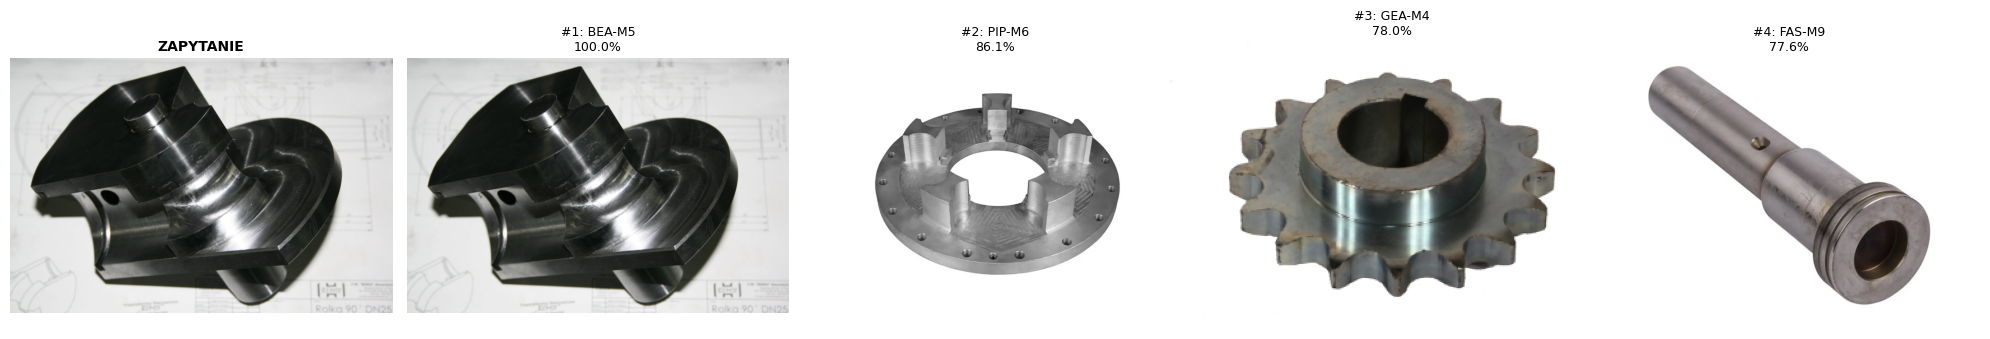


✓ Wyświetlono obraz zapytania i 4 najbardziej podobnych części


In [54]:
# test 6: wizualizacja wyników
print("\n" + "="*70)
print("TEST 6: Wyświetlanie obrazów znalezionych części")
print("="*70)

%pip install -q matplotlib
from PIL import Image
import matplotlib.pyplot as plt

test_image3 = "obrazy/metal/m5.webp"
result6 = rag_search_metal_parts(
    query="Część z obrazu",
    query_type="image",
    image_path=test_image3,
    top_k=4
)

display_search_results(result6)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

if Path(test_image3).exists():
    axes[0].imshow(Image.open(test_image3))
    axes[0].set_title("ZAPYTANIE", fontsize=10, fontweight='bold')
else:
    axes[0].text(0.5, 0.5, "Obraz zapytania\nnie znaleziono", horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)
    axes[0].set_title("ZAPYTANIE", fontsize=10, fontweight='bold')
axes[0].axis('off')

with SessionLocal() as db:
    for idx, (part_dict, score) in enumerate(result6['results'][:4]):
        part_db = db.query(PartDB).filter_by(part_id=part_dict['part_id']).first()
        if part_db and part_db.image_path and Path(part_db.image_path).exists():
            img = Image.open(part_db.image_path)
            axes[idx+1].imshow(img)
            axes[idx+1].set_title(f"#{idx+1}: {part_dict['part_id']}\n{score*100:.1f}%",
                                 fontsize=9)
            axes[idx+1].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Wyświetlono obraz zapytania i {len(result6['results'])} najbardziej podobnych części")

In [55]:
# test 5: wyszukiwanie hybrydowe
print("\n" + "="*70)
print("TEST 5: Wyszukiwanie hybrydowe (tekst + obraz)")
print("="*70)

test_image2 = "obrazy/metal/m3.jpg"
print(f"Wyszukiwanie: tekst + obraz ({test_image2})")

result5 = rag_search_metal_parts(
    query="Łożysko kulkowe do maszyny przemysłowej",
    query_type="hybrid",
    image_path=test_image2,
    top_k=3
)

print(f"\nQuery: {result5['query']}")
print(f"Typ: {result5['query_type']}")
print(f"Obraz zapytania: {test_image2}")
print(f"\nRaport:\n{result5['report']}")


TEST 5: Wyszukiwanie hybrydowe (tekst + obraz)
Wyszukiwanie: tekst + obraz (obrazy/metal/m3.jpg)

Query: Łożysko kulkowe do maszyny przemysłowej
Typ: hybrid
Obraz zapytania: obrazy/metal/m3.jpg

Raport:
RAPORT WYSZUKIWANIA
Zapytanie: Łożysko kulkowe do maszyny przemysłowej
Znaleziono: 3 części


#1 (Dopasowanie: 33.1%)
  ID: FAS-M10
  Opis: Fastener
  Materiał: Aluminium
  Kategoria: fasteners
  Wymiary: {'source': 'clip_embedding'}
  Tagi: metal, part, fasteners, clip_classified, obrazy/metal/m10.webp

#2 (Dopasowanie: 30.0%)
  ID: WAS-M3
  Opis: Washer
  Materiał: Aluminium
  Kategoria: washers
  Wymiary: {'source': 'clip_embedding'}
  Tagi: metal, part, washers, clip_classified, obrazy/metal/m3.jpg

#3 (Dopasowanie: 23.3%)
  ID: GEA-M4
  Opis: Gear
  Materiał: Aluminium
  Kategoria: gears
  Wymiary: {'source': 'clip_embedding'}
  Tagi: metal, part, gears, clip_classified, obrazy/metal/m4.jpg




In [56]:
# test 4: wyszukiwanie obrazowe dla wszystkich plików
print("\n" + "="*70)
print("TEST 4: Wyszukiwanie na podstawie obrazu (dla wszystkich obrazów)")
print("="*70)

import glob

image_files = glob.glob("obrazy/metal/*.jpg") + glob.glob("obrazy/metal/*.webp")

if not image_files:
    print("Brak plików obrazów w katalogu 'obrazy/metal'. Upewnij się, że obrazy są przesłane.")
else:
    print(f"\n✓ Znalezione {len(image_files)} plików obrazów\n")
    for idx, test_image in enumerate(image_files, 1):
        print(f"[{idx}/{len(image_files)}] Plik: {test_image}")
        print(f"  Wyszukiwanie podobnych części...")

        result4 = rag_search_metal_parts(
            query="Część metalowa z obrazu",
            query_type="image",
            image_path=test_image,
            top_k=3
        )

        print(f"  ✓ Query: {result4['query']}")
        print(f"  ✓ Typ: {result4['query_type']}")
        print(f"  ✓ Znalezione wyniki: {len(result4['results'])}\n")


TEST 4: Wyszukiwanie na podstawie obrazu (dla wszystkich obrazów)

✓ Znalezione 22 plików obrazów

[1/22] Plik: obrazy/metal/m15.jpg
  Wyszukiwanie podobnych części...
  ✓ Query: Część metalowa z obrazu
  ✓ Typ: image
  ✓ Znalezione wyniki: 3

[2/22] Plik: obrazy/metal/m1.jpg
  Wyszukiwanie podobnych części...
  ✓ Query: Część metalowa z obrazu
  ✓ Typ: image
  ✓ Znalezione wyniki: 3

[3/22] Plik: obrazy/metal/m3.jpg
  Wyszukiwanie podobnych części...
  ✓ Query: Część metalowa z obrazu
  ✓ Typ: image
  ✓ Znalezione wyniki: 3

[4/22] Plik: obrazy/metal/m22.jpg
  Wyszukiwanie podobnych części...
  ✓ Query: Część metalowa z obrazu
  ✓ Typ: image
  ✓ Znalezione wyniki: 3

[5/22] Plik: obrazy/metal/m13.jpg
  Wyszukiwanie podobnych części...
  ✓ Query: Część metalowa z obrazu
  ✓ Typ: image
  ✓ Znalezione wyniki: 3

[6/22] Plik: obrazy/metal/m7.jpg
  Wyszukiwanie podobnych części...
  ✓ Query: Część metalowa z obrazu
  ✓ Typ: image
  ✓ Znalezione wyniki: 3

[7/22] Plik: obrazy/metal/m11.jpg

## Test 4: Wyszukiwanie na podstawie obrazu

## 10. Statystyki i Podsumowanie

In [57]:
# statystyki bazy
with SessionLocal() as db:
    total_parts = db.query(PartDB).count()
    by_category = {}
    for part in db.query(PartDB).all():
        cat = part.category or "unknown"
        by_category[cat] = by_category.get(cat, 0) + 1

    search_logs = db.query(SearchLog).all()

    print("\n" + "="*70)
    print("STATYSTYKI BAZY DANYCH")
    print("="*70)
    print(f"Łączna liczba części: {total_parts}")
    print(f"\nPodzielenie po kategoriach:")
    for cat, count in by_category.items():
        print(f"  - {cat}: {count}")
    print(f"\nLiczba przeprowadzonych wyszukiwań: {len(search_logs)}")

    if search_logs:
        print(f"\nOstatnie wyszukiwania:")
        for log in search_logs[-5:]:
            print(f"  - {log.query_type}: '{log.query}' → {log.results_count} wyników")


STATYSTYKI BAZY DANYCH
Łączna liczba części: 23

Podzielenie po kategoriach:
  - pipes: 3
  - fasteners: 9
  - bearings: 4
  - springs: 1
  - washers: 2
  - screws: 2
  - gears: 1
  - bolts: 1

Liczba przeprowadzonych wyszukiwań: 27

Ostatnie wyszukiwania:
  - image: 'Część metalowa z obrazu' → 3 wyników
  - image: 'Część metalowa z obrazu' → 3 wyników
  - image: 'Część metalowa z obrazu' → 3 wyników
  - image: 'Część metalowa z obrazu' → 3 wyników
  - image: 'Część metalowa z obrazu' → 3 wyników


In [58]:
# podgląd bazy danych
print("\n" + "="*90)
print("ZAWARTOŚĆ BAZY DANYCH - WSZYSTKIE CZĘŚCI METALOWE")
print("="*90)

with SessionLocal() as db:
    all_parts = db.query(PartDB).all()
    
    if not all_parts:
        print("\n⚠ Baza danych jest pusta")
        print("   Uruchom komórkę 17 aby przetworzyć obrazy\n")
    else:
        print(f"\nLiczba części: {len(all_parts)}\n")
        
        print(f"{'#':<4} | {'Part ID':<15} | {'Nazwa':<25} | {'Kategoria':<12} | {'Materiał':<20} | {'Data':<19}")
        print(f"{'-'*4}-+-{'-'*15}-+-{'-'*25}-+-{'-'*12}-+-{'-'*20}-+-{'-'*19}")
        
        for i, part in enumerate(all_parts, 1):
            part_id = part.part_id[:15]
            name = part.description[:25]
            category = part.category[:12] if part.category else "N/A"
            material = part.material[:20] if part.material else "N/A"
            created = part.created_at[:19] if part.created_at else "N/A"
            
            print(f"{i:<4} | {part_id:<15} | {name:<25} | {category:<12} | {material:<20} | {created:<19}")
        
        print(f"\n{'-'*90}")
        
        by_category = {}
        by_material = {}
        for part in all_parts:
            cat = part.category or "unknown"
            mat = part.material or "unknown"
            by_category[cat] = by_category.get(cat, 0) + 1
            by_material[mat] = by_material.get(mat, 0) + 1
        
        print(f"\n📊 STATYSTYKI:")
        print(f"\nPo kategoriach:")
        for cat, count in sorted(by_category.items(), key=lambda x: x[1], reverse=True):
            print(f"   {cat:.<30} {count:>3}")
        
        print(f"\nPo materiałach:")
        for mat, count in sorted(by_material.items(), key=lambda x: x[1], reverse=True):
            print(f"   {mat:.<30} {count:>3}")
        
        print(f"\n{'-'*90}")
        
        if all_parts:
            print(f"\n📋 PRZYKŁAD - Szczegóły pierwszej części:")
            first = all_parts[0]
            print(f"\n   ID:          {first.part_id}")
            print(f"   Nazwa:       {first.description}")
            print(f"   Kategoria:   {first.category}")
            print(f"   Materiał:    {first.material}")
            print(f"   Wymiary:     {first.dimensions}")
            print(f"   Tagi:        {first.tags}")
            print(f"   Obraz:       {first.image_path}")
            print(f"   Utworzono:   {first.created_at}")
            print(f"\n{'='*90}\n")


ZAWARTOŚĆ BAZY DANYCH - WSZYSTKIE CZĘŚCI METALOWE

Liczba części: 23

#    | Part ID         | Nazwa                     | Kategoria    | Materiał             | Data               
-----+-----------------+---------------------------+--------------+----------------------+--------------------
1    | PIP-M1          | Pipe                      | pipes        | Tytan                | 2026-01-30T17:13:31
2    | FAS-M10         | Fastener                  | fasteners    | Aluminium            | 2026-01-30T17:13:31
3    | FAS-M11         | Fastener                  | fasteners    | Tytan                | 2026-01-30T17:13:31
4    | FAS-M12         | Fastener                  | fasteners    | Aluminium            | 2026-01-30T17:13:31
5    | BEA-M13         | Bearing                   | bearings     | Tytan                | 2026-01-30T17:13:31
6    | BEA-M14         | Bearing                   | bearings     | Tytan                | 2026-01-30T17:13:31
7    | SPR-M15         | Spring          

In [59]:
# diagnostyka wyszukiwań obrazowych
print("\n" + "="*70)
print("DIAGNOSTYKA: Analiza wyszukiwań obrazowych")
print("="*70)

with SessionLocal() as db:
    image_searches = db.query(SearchLog).filter_by(query_type="image").all()
    print(f"\nLiczba wyszukiwań obrazowych: {len(image_searches)}")
    
    if image_searches:
        print(f"\nLista wszystkich image searches:")
        for i, log in enumerate(image_searches, 1):
            print(f"  {i}. Query: '{log.query}' | Timestamp: {log.timestamp} | Wyniki: {log.results_count}")
    
    text_searches = db.query(SearchLog).filter_by(query_type="text").count()
    hybrid_searches = db.query(SearchLog).filter_by(query_type="hybrid").count()
    
    print(f"\nPodsumowanie:")
    print(f"  - Tekst (text): {text_searches}")
    print(f"  - Obraz (image): {len(image_searches)}")
    print(f"  - Hybrydowe (hybrid): {hybrid_searches}")
    print(f"  - RAZEM: {text_searches + len(image_searches) + hybrid_searches}")


DIAGNOSTYKA: Analiza wyszukiwań obrazowych

Liczba wyszukiwań obrazowych: 23

Lista wszystkich image searches:
  1. Query: 'Część z obrazu' | Timestamp: 2026-01-30T17:13:33.538331 | Wyniki: 4
  2. Query: 'Część metalowa z obrazu' | Timestamp: 2026-01-30T17:13:34.312336 | Wyniki: 3
  3. Query: 'Część metalowa z obrazu' | Timestamp: 2026-01-30T17:13:34.348368 | Wyniki: 3
  4. Query: 'Część metalowa z obrazu' | Timestamp: 2026-01-30T17:13:34.397584 | Wyniki: 3
  5. Query: 'Część metalowa z obrazu' | Timestamp: 2026-01-30T17:13:34.434266 | Wyniki: 3
  6. Query: 'Część metalowa z obrazu' | Timestamp: 2026-01-30T17:13:34.480061 | Wyniki: 3
  7. Query: 'Część metalowa z obrazu' | Timestamp: 2026-01-30T17:13:34.517673 | Wyniki: 3
  8. Query: 'Część metalowa z obrazu' | Timestamp: 2026-01-30T17:13:34.554291 | Wyniki: 3
  9. Query: 'Część metalowa z obrazu' | Timestamp: 2026-01-30T17:13:34.589474 | Wyniki: 3
  10. Query: 'Część metalowa z obrazu' | Timestamp: 2026-01-30T17:13:34.634230 | Wyniki

In [60]:
# przetwórz wszystkie obrazy i zapisz do bazy

print("\n" + "="*80)
print("PRZYGOTOWANIE: CZYSZCZENIE BAZY DANYCH")
print("="*80)

with SessionLocal() as db:
    deleted_parts = db.query(PartDB).count()
    deleted_logs = db.query(SearchLog).count()
    
    db.query(PartDB).delete()
    db.query(SearchLog).delete()
    db.commit()
    
    print(f"✓ Usunięto {deleted_parts} części")
    print(f"✓ Usunięto {deleted_logs} logów wyszukiwań")
    print(f"✓ Baza danych wyczyszczona i gotowa do użycia")

print("\n" + "="*80)
print("PRZETWARZANIE: WSZYSTKIE OBRAZY Z FOLDERU 'obrazy/metal/'")
print("="*80)

from pathlib import Path
import re

# Qwen do weryfikacji, aby nie zapisywać niemetalowych elementów
VERIFY_THRESHOLD = 0.7
verifier_batch = None
try:
    from qwen_image_verifier import QwenImageVerifier
    import torch

    print("🔄 Ładowanie Qwen2-VL-7B-Instruct do weryfikacji wsadowej...")
    verifier_batch = QwenImageVerifier(
        model_id="Qwen/Qwen2-VL-7B-Instruct",
        device="cuda" if torch.cuda.is_available() else "cpu",
    )
    print("✅ Qwen załadowany (batch)")
except Exception as e:
    print(f"⚠ Nie udało się załadować Qwen dla wsadu: {e}")
    print("   Przerywam wsadowe dodawanie, aby nie dodać niemetalowych części.")


def natural_sort_key(path):
    """Klucz do sortowania naturalnego (m1, m2, m10 zamiast m1, m10, m2)."""
    return [int(text) if text.isdigit() else text.lower() 
            for text in re.split('([0-9]+)', str(path.name))]

image_folder = Path("obrazy/metal/")
image_extensions = ['.jpg', '.jpeg', '.png', '.webp', '.bmp']
all_images = []

for ext in image_extensions:
    all_images.extend(image_folder.glob(f"*{ext}"))
    all_images.extend(image_folder.glob(f"*{ext.upper()}"))

# Usuń duplikaty zachowując kolejność, potem sortuj naturalnie
seen = set()
unique_images = []
for img in all_images:
    if img not in seen:
        seen.add(img)
        unique_images.append(img)

all_images = sorted(unique_images, key=natural_sort_key)

print(f"\n📂 Znaleziono {len(all_images)} obrazów do przetworzenia")
print(f"📡 Metoda rozpoznawania: {'OpenAI API' if OPENAI_API_KEY else 'CLIP Embedding (lokalnie)'}\n")

if not all_images:
    print("⚠ Brak obrazów w folderze obrazy/metal/")
    print("   Upewnij się że obrazy są w folderze i uruchom ponownie.")
elif verifier_batch is None:
    print("❌ Weryfikator Qwen niedostępny – pomijam wsad, aby nie zapisać niemetalowych zdjęć.")
else:
    processed_parts = []
    claim_text = (
        "To jest część metalowa używana w przemyśle (śruba, nakrętka, łożysko, "
        "wał, sprężyna lub inna część mechaniczna)."
    )
    
    for i, image_path in enumerate(all_images, 1):
        print(f"\n[{i}/{len(all_images)}] {'='*60}")
        print(f"📷 Plik: {image_path.name}")
        print(f"{'='*70}")
        
        try:
            # Weryfikacja metalowości przez Qwen
            result = verifier_batch.verify(
                image_path=str(image_path),
                claim=claim_text,
                max_new_tokens=256,
                temperature=0.1,
            )

            if result.verdict != "yes" or result.confidence < VERIFY_THRESHOLD:
                print(
                    f"❌ Odrzucono przez Qwen (verdict={result.verdict}, "
                    f"conf={result.confidence:.0%})"
                )
                continue

            print(
                f"✅ Qwen potwierdził część metalową (conf={result.confidence:.0%})"
            )

            # Klasyfikacja szczegółowa dopiero po akceptacji Qwen
            part = classify_metal_part_from_image(str(image_path))
            
            if part:
                processed_parts.append(part)
                print(f"\n✓ ROZPOZNANO:")
                print(f"   Part ID:    {part.part_id}")
                print(f"   Nazwa:      {part.description}")
                print(f"   Kategoria:  {part.category}")
                print(f"   Materiał:   {part.material}")
            else:
                print(f"\n✗ Nie udało się rozpoznać po weryfikacji Qwen")
                
        except Exception as e:
            print(f"\n✗ Błąd: {e}")
    
    print(f"\n{'='*80}")
    print(f"ZAPISYWANIE DO BAZY DANYCH: {len(processed_parts)} CZĘŚCI")
    print(f"{'='*80}\n")
    
    with SessionLocal() as db:
        success_count = 0
        for part in processed_parts:
            if add_part_to_db(db, part):
                success_count += 1
                print(f"✓ {part.part_id}: {part.description}")
                print(f"  └─ {part.category} | {part.material}")
        
        print(f"\n{'='*80}")
        print(f"✓✓✓ ZAKOŃCZONO POMYŚLNIE ✓✓✓")
        print(f"{'='*80}")
        print(f"Zapisano:        {success_count}/{len(processed_parts)} części")
        print(f"Baza danych:     metal_parts.db")
        print(f"Tabela:          metal_parts")
        print(f"{'='*80}\n")
        
        print("📋 Przykładowe rekordy w bazie:\n")
        sample_parts = db.query(PartDB).limit(3).all()
        for p in sample_parts:
            print(f"   • {p.part_id}: {p.description} ({p.category}, {p.material})")



PRZYGOTOWANIE: CZYSZCZENIE BAZY DANYCH
✓ Usunięto 23 części
✓ Usunięto 27 logów wyszukiwań
✓ Baza danych wyczyszczona i gotowa do użycia

PRZETWARZANIE: WSZYSTKIE OBRAZY Z FOLDERU 'obrazy/metal/'
🔄 Ładowanie Qwen2-VL-7B-Instruct do weryfikacji wsadowej...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

✅ Qwen załadowany (batch)

📂 Znaleziono 23 obrazów do przetworzenia
📡 Metoda rozpoznawania: CLIP Embedding (lokalnie)


[1/23] ============================================================
📷 Plik: m1.jpg
✅ Qwen potwierdził część metalową (conf=90%)
   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Pipe (pipes)

✓ ROZPOZNANO:
   Part ID:    PIP-M1
   Nazwa:      Pipe
   Kategoria:  pipes
   Materiał:   Tytan

[2/23] ============================================================
📷 Plik: m2.webp
✅ Qwen potwierdził część metalową (conf=90%)
   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Fastener (fasteners)

✓ ROZPOZNANO:
   Part ID:    FAS-M2
   Nazwa:      Fastener
   Kategoria:  fasteners
   Materiał:   Aluminium

[3/23] ============================================================
📷 Plik: m3.jpg
✅ Qwen

In [61]:
# Generowanie szkicu technicznego z obrazu (edge detection)

%pip install -q opencv-python

import cv2
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt


def generate_technical_sketch(image_path: str, output_path: str = None, 
                              method: str = "canny", show: bool = True) -> str:
    """
    Generuje szkic techniczny (kontur) z obrazu części metalowej.
    
    Args:
        image_path: Ścieżka do obrazu wejściowego
        output_path: Ścieżka do zapisu szkicu (opcjonalne)
        method: "canny", "sobel", "laplacian", "adaptive"
        show: Czy wyświetlić wynik
    
    Returns:
        Ścieżka do zapisanego szkicu
    """
    # Wczytaj obraz
    img = cv2.imread(str(image_path))
    if img is None:
        raise FileNotFoundError(f"Nie można wczytać: {image_path}")
    
    # Konwersja do skali szarości
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Redukcja szumu
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Wybór metody detekcji krawędzi
    if method == "canny":
        # Canny - najlepsza do szkiców technicznych
        edges = cv2.Canny(blurred, 50, 150)
        
    elif method == "sobel":
        # Sobel - gradienty w X i Y
        sobel_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
        edges = np.sqrt(sobel_x**2 + sobel_y**2)
        edges = np.uint8(255 * edges / edges.max())
        
    elif method == "laplacian":
        # Laplacian - detekcja krawędzi 2D
        edges = cv2.Laplacian(blurred, cv2.CV_64F)
        edges = np.uint8(np.absolute(edges))
        
    elif method == "adaptive":
        # Adaptive threshold - dla zróżnicowanego oświetlenia
        edges = cv2.adaptiveThreshold(
            blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY_INV, 11, 2
        )
    else:
        raise ValueError(f"Nieznana metoda: {method}")
    
    # Inwersja - białe linie na czarnym tle → czarne linie na białym tle
    sketch = 255 - edges
    
    # Opcjonalne: pogrubienie linii
    kernel = np.ones((2, 2), np.uint8)
    sketch = cv2.erode(sketch, kernel, iterations=1)
    
    # Zapisz szkic
    if output_path is None:
        input_path = Path(image_path)
        output_path = input_path.parent / f"{input_path.stem}_sketch.png"
    
    cv2.imwrite(str(output_path), sketch)
    
    # Wyświetl porównanie
    if show:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Oryginalny obraz
        original = Image.open(image_path)
        axes[0].imshow(original)
        axes[0].set_title("Oryginał", fontsize=12)
        axes[0].axis('off')
        
        # Szkic
        axes[1].imshow(sketch, cmap='gray')
        axes[1].set_title(f"Szkic techniczny ({method})", fontsize=12)
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    print(f"✅ Szkic zapisany: {output_path}")
    return str(output_path)


def generate_all_sketch_variants(image_path: str, show: bool = True) -> dict:
    """
    Generuje szkice wszystkimi metodami dla porównania.
    """
    methods = ["canny", "sobel", "laplacian", "adaptive"]
    results = {}
    
    input_path = Path(image_path)
    
    if show:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        # Oryginał
        original = Image.open(image_path)
        axes[0].imshow(original)
        axes[0].set_title("ORYGINAŁ", fontsize=12, fontweight='bold')
        axes[0].axis('off')
    
    for i, method in enumerate(methods):
        output_path = input_path.parent / f"{input_path.stem}_sketch_{method}.png"
        
        try:
            sketch_path = generate_technical_sketch(
                image_path, 
                output_path=str(output_path),
                method=method,
                show=False
            )
            results[method] = sketch_path
            
            if show:
                sketch = cv2.imread(sketch_path, cv2.IMREAD_GRAYSCALE)
                axes[i+1].imshow(sketch, cmap='gray')
                axes[i+1].set_title(f"{method.upper()}", fontsize=11)
                axes[i+1].axis('off')
                
        except Exception as e:
            print(f"⚠️ Błąd {method}: {e}")
            results[method] = None
    
    if show:
        # Ukryj ostatnią pustą oś
        axes[-1].axis('off')
        plt.suptitle(f"Warianty szkiców: {input_path.name}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    return results


# Test na przykładowym obrazie
print("✅ Funkcje generowania szkiców załadowane")
print()
print("Użycie:")
print('  generate_technical_sketch("obrazy/metal/m1.jpg")')
print('  generate_all_sketch_variants("obrazy/metal/m1.jpg")')
print()
print("Metody: canny (domyślna), sobel, laplacian, adaptive")

Note: you may need to restart the kernel to use updated packages.
✅ Funkcje generowania szkiców załadowane

Użycie:
  generate_technical_sketch("obrazy/metal/m1.jpg")
  generate_all_sketch_variants("obrazy/metal/m1.jpg")

Metody: canny (domyślna), sobel, laplacian, adaptive


In [62]:
# opcjonalna rewalidacja istniejących rekordów Qwenem (raportuje, nie usuwa)
REVALIDATE_THRESHOLD = 0.7
REVALIDATE_LIMIT = None  # ustaw liczbę, aby ograniczyć liczbę sprawdzanych rekordów

try:
    from qwen_image_verifier import QwenImageVerifier
    import torch
except Exception as e:
    print(f"❌ Nie można załadować Qwen do rewalidacji: {e}")
else:
    verifier_reval = globals().get('verifier', None)
    if verifier_reval is None:
        print("🔄 Ładowanie Qwen2-VL-7B-Instruct do rewalidacji...")
        verifier_reval = QwenImageVerifier(
            model_id="Qwen/Qwen2-VL-7B-Instruct",
            device="cuda" if torch.cuda.is_available() else "cpu",
        )
        globals()['verifier'] = verifier_reval
    else:
        print("✅ Używam już załadowanego modelu Qwen do rewalidacji")

    claim_text = (
        "To jest część metalowa używana w przemyśle (śruba, nakrętka, łożysko, "
        "wał, sprężyna lub inna część mechaniczna)."
    )

    flagged = []
    checked = 0

    with SessionLocal() as db:
        parts = db.query(PartDB).all()
        if REVALIDATE_LIMIT:
            parts = parts[:REVALIDATE_LIMIT]

        for part in parts:
            if not part.image_path:
                continue
            img_path = Path(part.image_path)
            if not img_path.exists():
                flagged.append((part.part_id, "missing", 0.0, part.image_path, "plik nie istnieje"))
                continue
            try:
                res = verifier_reval.verify(
                    image_path=str(img_path),
                    claim=claim_text,
                    max_new_tokens=256,
                    temperature=0.1,
                )
                checked += 1
                if res.verdict != "yes" or res.confidence < REVALIDATE_THRESHOLD:
                    flagged.append((part.part_id, res.verdict, res.confidence, part.image_path, res.reason))
            except Exception as e:
                flagged.append((part.part_id, "error", 0.0, part.image_path, str(e)))

    print("\n=== REWALIDACJA BAZY (Qwen) ===")
    print(f"Sprawdzono: {checked} rekordów")
    if not flagged:
        print("✅ Wszystkie zweryfikowane rekordy wyglądają na metalowe (wg progu)")
    else:
        print(f"⚠ Do weryfikacji ręcznej: {len(flagged)}")
        for pid, verdict, conf, path, reason in flagged:
            print(f" - {pid}: verdict={verdict}, conf={conf:.0%}, path={path}")
            print(f"   reason: {reason}")


✅ Używam już załadowanego modelu Qwen do rewalidacji

=== REWALIDACJA BAZY (Qwen) ===
Sprawdzono: 18 rekordów
✅ Wszystkie zweryfikowane rekordy wyglądają na metalowe (wg progu)


In [ ]:
# === FRONTEND: Dodawanie nowych części metalowych ===
# Uruchom tę komórkę, aby wyświetlić interfejs do przesyłania zdjęć

%pip install ipywidgets

from pathlib import Path
from datetime import datetime
import os, io, base64
from PIL import Image
import ipywidgets as W
from IPython.display import display, HTML, clear_output

# Docelowy folder na obrazy
project_root = Path.cwd()
metal_dir = project_root / 'obrazy' / 'metal'
metal_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Folder docelowy: {metal_dir}")
print(f"📊 Baza danych: metal_parts.db")
print()

# ===== Widgety =====
# Pole na nazwę/podpis zdjęcia
txt_name = W.Text(
    placeholder='Wpisz nazwę zdjęcia (np. "śruba M8", "łożysko 6205")',
    description='Nazwa:',
    layout=W.Layout(width='400px')
)

# Upload pliku
file_upload = W.FileUpload(
    accept='.png,.jpg,.jpeg,.webp,.bmp',
    multiple=False,
    description='Wybierz zdjęcie'
)

# Przycisk zapisu
btn_save = W.Button(
    description='📥 Zapisz i klasyfikuj',
    button_style='success',
    icon='check',
    layout=W.Layout(width='200px')
)

# Obszar na komunikaty
output = W.Output()

# ===== Funkcje pomocnicze =====
def save_uploaded_image(raw_bytes: bytes, ext: str, name: str) -> Path:
    """
    Zapisz obraz do folderu metal z DOKŁADNĄ nazwą z formularza + rozszerzenie z pliku.
    
    Args:
        raw_bytes: Bajty obrazu
        ext: Rozszerzenie oryginalnego pliku (np. '.jpg', '.png')
        name: Nazwa wpisana przez użytkownika w polu "Nazwa:"
    
    Returns:
        Ścieżka do zapisanego pliku
    """
    # Użyj DOKŁADNIE nazwy wpisanej przez użytkownika
    # Usuń tylko najbardziej problematyczne znaki dla systemu plików
    import re
    forbidden_chars = r'[/\\:*?"<>|]'
    clean_name = re.sub(forbidden_chars, '', name).strip()
    
    if not clean_name:
        clean_name = 'bez_nazwy'
    
    # Rozszerzenie z oryginalnego pliku (np. .jpg, .png)
    final_ext = ext.lower() if ext else '.png'
    if not final_ext.startswith('.'):
        final_ext = '.' + final_ext
    
    # Pełna nazwa pliku: dokładna nazwa + rozszerzenie
    filename = f"{clean_name}{final_ext}"
    filepath = metal_dir / filename
    
    # Jeśli plik istnieje - nadpisz go
    Image.open(io.BytesIO(raw_bytes)).save(filepath)
    
    return filepath


def find_similar_parts_for_image(image_path: str, top_k: int = 5, category_hint: Optional[str] = None):
    """Znajdź podobne części z bazy na podstawie embeddingu obrazu."""
    if not Path(image_path).exists():
        return []

    with SessionLocal() as db:
        results = search_parts_by_image(
            db,
            image_path=image_path,
            top_k=top_k,
            category_filter=category_hint
        )

        ranked = []
        for idx, (part, score) in enumerate(results, 1):
            ranked.append({
                "rank": idx,
                "part_id": part.part_id,
                "description": part.description,
                "material": part.material,
                "category": part.category,
                "image_path": part.image_path,
                "score": float(score),
            })

    return ranked


# ===== Handler przycisku =====
def on_save_click(_):
    output.clear_output()
    
    with output:
        # 1. Walidacja: nazwa
        name = txt_name.value.strip()
        if not name:
            print('⚠️ Proszę wpisać nazwę zdjęcia!')
            return
        
        # 2. Walidacja: plik
        if not file_upload.value:
            print('⚠️ Proszę wybrać zdjęcie do przesłania!')
            return
        
        try:
            # 3. Pobierz dane z uploadu
            val = file_upload.value
            
            # Normalizacja formatu (różne wersje ipywidgets)
            if isinstance(val, dict):
                entries = list(val.values())
            elif isinstance(val, (list, tuple)):
                entries = list(val)
            else:
                entries = [val]
            
            if len(entries) != 1:
                print(f'⚠️ Prześlij dokładnie 1 zdjęcie (wybrano: {len(entries)})')
                return
            
            uploaded = entries[0]
            
            # Wydobądź bajty i nazwę pliku
            raw = None
            filename = None
            
            if isinstance(uploaded, dict):
                raw = uploaded.get('content')
                filename = uploaded.get('name') or (uploaded.get('metadata') or {}).get('name')
                
                # Szukaj bajtów w innych polach
                if raw is None:
                    for v in uploaded.values():
                        if isinstance(v, (bytes, bytearray, memoryview)):
                            raw = v
                            break
            
            # Konwertuj memoryview na bytes
            if isinstance(raw, memoryview):
                raw = bytes(raw)
            
            if not isinstance(raw, (bytes, bytearray)):
                print('❌ Nie udało się odczytać pliku. Spróbuj ponownie.')
                print(f'   Debug: typ={type(uploaded)}, klucze={uploaded.keys() if isinstance(uploaded, dict) else "N/A"}')
                return
            
            # 4. Zapisz obraz do folderu metal
            ext = os.path.splitext(filename or name)[1].lower() or '.png'
            saved_path = save_uploaded_image(raw, ext, name)
            
            print(f'✅ Zapisano: {saved_path.name}')
            print(f'📂 Lokalizacja: obrazy/metal/{saved_path.name}')
            print()
            
            # 📐 GENEROWANIE SZKICU TECHNICZNEGO
            print('='*60)
            print('📐 GENEROWANIE SZKICU TECHNICZNEGO')
            print('='*60)
            
            try:
                sketch_path = generate_technical_sketch(
                    str(saved_path),
                    method="canny",
                    show=True
                )
                print(f'📁 Szkic zapisany: {sketch_path}')
            except Exception as e:
                print(f'⚠️ Nie udało się wygenerować szkicu: {e}')
            
            print()
            print('='*60)
            print('🔍 KLASYFIKACJA OBRAZU PRZEZ QWEN')
            print('='*60)
            
            # 5. Załaduj Qwen jeśli nie jest załadowany
            try:
                from qwen_image_verifier import QwenImageVerifier
                import torch
                
                # Sprawdź czy verifier już istnieje jako zmienna globalna
                verifier_instance = globals().get('verifier', None)
                
                if verifier_instance is None:
                    print('🔄 Ładowanie modelu Qwen2-VL-7B-Instruct...')
                    verifier_instance = QwenImageVerifier(
                        model_id="Qwen/Qwen2-VL-7B-Instruct",
                        device="cuda" if torch.cuda.is_available() else "cpu"
                    )
                    globals()['verifier'] = verifier_instance
                    print('✅ Model załadowany!\n')
                else:
                    print('✅ Używam już załadowanego modelu Qwen\n')
            except Exception as e:
                print(f'❌ Błąd ładowania Qwen: {e}')
                print('   Kontynuuję ze starą metodą klasyfikacji...\n')
                verifier_instance = None
            
            # 6. Klasyfikuj obraz przez Qwen
            if verifier_instance:
                print('🤖 Weryfikacja przez Qwen Vision AI...')
                result = verifier_instance.verify(
                    image_path=str(saved_path),
                    claim="To jest część metalowa używana w przemyśle (śruba, nakrętka, łożysko, wał, sprężyna lub inna część mechaniczna)",
                    max_new_tokens=300,
                    temperature=0.2
                )
                
                print(f'   Verdict: {result.verdict.upper()}')
                print(f'   Confidence: {result.confidence:.0%}')
                print(f'   Analiza: {result.reason}')
                print()
                
                if result.verdict != "yes" or result.confidence < 0.5:
                    print('❌ KLASYFIKACJA ODRZUCONA!')
                    print('='*60)
                    print('⚠️ Qwen nie rozpoznał na obrazie części metalowej.')
                    print('   Proszę przesłać poprawne zdjęcie części metalowej.')
                    print('='*60)
                    return
                
                print('✅ Qwen potwierdził: to jest część metalowa!')
                print()
            
            # 7. Klasyfikuj szczegóły części
            part = classify_metal_part_from_image(str(saved_path))
            
            if part:
                print()
                print('✅ Rozpoznano część:')
                print(f'   📋 Part ID:   {part.part_id}')
                print(f'   📝 Nazwa:     {part.description}')
                print(f'   📁 Kategoria: {part.category}')
                print(f'   🔧 Materiał:  {part.material}')
                print()
                
                # 8. Ranking podobnych części w bazie
                similar = find_similar_parts_for_image(str(saved_path), top_k=5, category_hint=part.category)
                if similar:
                    print('📊 Ranking podobnych (1-5):')
                    for row in similar:
                        print(f"  #{row['rank']}: {row['description']} [{row['part_id']}] ({row['category']}, {row['material']}) | score: {row['score']:.4f}")
                        if row.get('image_path'):
                            print(f"     Obraz: {row['image_path']}")
                    print()
                else:
                    print('📊 Brak podobnych części w bazie (brak embeddingów lub pusta baza).\n')
                
                # 9. Dodaj do bazy danych
                print('💾 Zapisywanie do bazy danych...')
                with SessionLocal() as db:
                    existing = db.query(PartDB).filter_by(image_path=str(saved_path)).first()
                    if existing:
                        print(f'⚠️ Obraz już istnieje w bazie jako: {existing.part_id}')
                    else:
                        success = add_part_to_db(db, part)
                        if success:
                            total = db.query(PartDB).count()
                            print()
                            print('='*60)
                            print('✅ GOTOWE!')
                            print('='*60)
                            print(f'📊 Baza zawiera teraz: {total} części')
                            print(f'📁 Plik: {saved_path.name}')
                            print(f'🆔 Part ID: {part.part_id}')
                            print('='*60)
                            
                            # 🔥 OZNACZ FORMULARZ JAKO WYPEŁNIONY
                            set_form_complete(str(saved_path), part)
                        else:
                            print('❌ Błąd podczas zapisywania do bazy')
                
                # 10. 🛒 WYSZUKIWANIE OFERT ONLINE
                print()
                print('='*60)
                print('🛒 WYSZUKIWANIE OFERT ONLINE')
                print('='*60)
                
                try:
                    from online_offer_finder import OfferFinder
                    
                    finder = OfferFinder(use_proxies=False)
                    
                    # Buduj zapytanie z opisu części
                    search_query = f"{part.description} {part.material}"
                    
                    print(f'🔍 Szukam tekstowo: "{search_query}"')
                    print()
                    
                    # Wyszukaj na wszystkich platformach tekstowo
                    offers = finder.search_all_platforms(
                        search_query,
                        platforms=["allegro", "amazon", "ebay", "aliexpress", "google"],
                        max_results_per_platform=1
                    )
                    
                    if offers:
                        print()
                        print('='*60)
                        print('📋 LINKI DO OFERT (wyszukiwanie tekstowe):')
                        print('='*60)
                        
                        for i, offer in enumerate(offers, 1):
                            print(f'\n{i}. {offer.source.upper()}')
                            print(f'   📝 {offer.title}')
                            print(f'   🔗 {offer.url}')
                    
                    # 🖼️ WYSZUKIWANIE ODWROTNE OBRAZEM - znajdź źródło zdjęcia
                    print()
                    print()
                    print('='*60)
                    print('🖼️ WYSZUKIWANIE OBRAZEM (REVERSE IMAGE SEARCH)')
                    print('='*60)
                    print('Użyj tych linków, aby znaleźć DOKŁADNIE ten sam produkt')
                    print('lub stronę, skąd pochodzi to zdjęcie:')
                    print('='*60)
                    
                    # Wyszukaj obrazem
                    image_offers = finder.reverse_image_search_all(str(saved_path))
                    
                    if image_offers:
                        print()
                        print('📋 LINKI DO WYSZUKIWANIA OBRAZEM:')
                        print('='*60)
                        
                        for i, offer in enumerate(image_offers, 1):
                            print(f'\n{i}. {offer.title}')
                            print(f'   📝 {offer.description}')
                            print(f'   🔗 {offer.url}')
                        
                        print()
                        print('='*60)
                        print('💡 INSTRUKCJA:')
                        print('   1. Otwórz dowolny link powyżej')
                        print('   2. Załaduj/przeciągnij obraz: ' + str(saved_path))
                        print('   3. Wyszukiwarka pokaże źródło zdjęcia i podobne produkty')
                        print('='*60)
                    
                except Exception as e:
                    print(f'⚠️ Błąd wyszukiwania ofert: {e}')
            else:
                print()
                print('❌ Nie udało się rozpoznać obrazu')
                print(f'   Plik został zapisany w: {saved_path}')
            
            # 10. Wyczyść formularz
            txt_name.value = ''
            try:
                file_upload.value = ()
            except:
                try:
                    file_upload.value = []
                except:
                    pass
                    
        except Exception as e:
            print(f'❌ Błąd: {e}')
            import traceback
            traceback.print_exc()

btn_save.on_click(on_save_click)

# ===== Wyświetl UI =====
ui = W.VBox([
    W.HTML('<h3>📷 Dodaj nową część metalową</h3>'),
    W.HTML('<p>Wpisz nazwę zdjęcia, wybierz plik i kliknij przycisk.</p>'),
    txt_name,
    file_upload,
    btn_save,
    W.HTML('<hr>'),
    output
])

display(ui)


Note: you may need to restart the kernel to use updated packages.
📁 Folder docelowy: /home/user/Vision_Picture_RAG/Vision_Picture_RAG/obrazy/metal
📊 Baza danych: metal_parts.db



# 🔍 Qwen Vision LLM - Weryfikacja Obrazów Części Metalowych

Ta sekcja demonstruje użycie **Qwen2-VL-7B-Instruct** do inteligentnej weryfikacji obrazów.  
Model weryfikuje czy obraz części metalowej zgadza się z opisem tekstowym.

**Przykłady zastosowań:**
- Kontrola jakości: "Czy to śruba M8?"
- Weryfikacja zamówień: "Czy otrzymana część to stal nierdzewna?"
- Automatyczna klasyfikacja: "Czy to łożysko kulkowe?"

In [64]:
# Import Qwen Image Verifier
from qwen_image_verifier import QwenImageVerifier, VerificationResult
import json
from pathlib import Path

# Inicjalizacja modelu (może potrwać ~1-2 minuty przy pierwszym uruchomieniu)
print("🔄 Ładowanie Qwen2-VL-7B-Instruct...")
print("   (Model ~16GB, pierwsze uruchomienie pobierze model z HuggingFace)")
print("   Używam transformers 4.47.1 (stabilna wersja)")

verifier = QwenImageVerifier(
    model_id="Qwen/Qwen2-VL-7B-Instruct",
    device="cuda" if __import__('torch').cuda.is_available() else "cpu"
)

print("✅ Model załadowany i gotowy do użycia!")
print(f"   Device: {verifier.device}")
print(f"   Model: {verifier.model_id}")

🔄 Ładowanie Qwen2-VL-7B-Instruct...
   (Model ~16GB, pierwsze uruchomienie pobierze model z HuggingFace)
   Używam transformers 4.47.1 (stabilna wersja)


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


✅ Model załadowany i gotowy do użycia!
   Device: cuda
   Model: Qwen/Qwen2-VL-7B-Instruct


## Test 1: Weryfikacja Śruby M8

🔍 WERYFIKACJA WYSŁANEGO OBRAZU PRZEZ QWEN
📷 Obraz: /home/user/Vision_Picture_RAG/Vision_Picture_RAG/obrazy/metal/m.webp
📝 Claim: Hinge - Aluminium - kategoria: hinges

📊 WYNIK:
   Verdict: YES
   Confidence: 100.0%
   Reason: The image shows a metal part that appears to be a hinge, and the material looks like aluminum.
💾 Zapisano wynik weryfikacji do bazy (ID: 141)


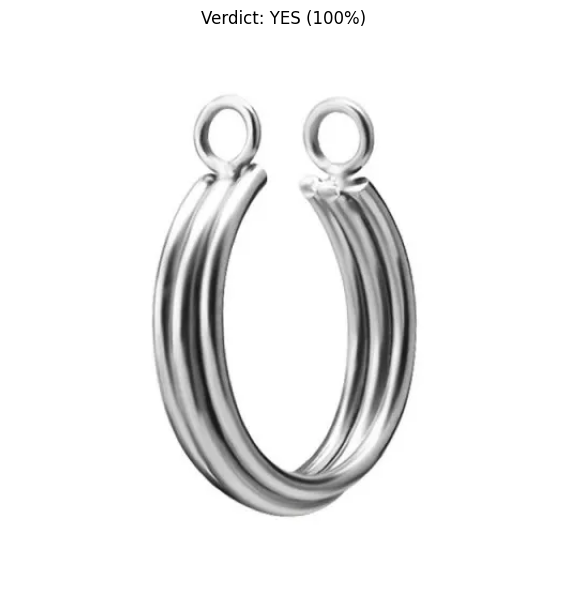

In [65]:
# Test 1: Weryfikacja wysłanego obrazu przez Qwen
# Priorytet: użyj danych z formularza, w przeciwnym razie fallback na już załadowane dane
if FORM_DATA.get('form_complete') and FORM_DATA.get('last_uploaded_image'):
    test_image = FORM_DATA['last_uploaded_image']
    part_info = FORM_DATA['last_part_info']
else:
    fallback_part = globals().get('part_info') or (processed_parts[0] if 'processed_parts' in globals() and processed_parts else None)
    if fallback_part and getattr(fallback_part, "image_path", None):
        test_image = fallback_part.image_path
        part_info = fallback_part
        print("ℹ️ Formularz pominięty – używam obrazu z już załadowanych danych.")
        print(f"📷 Obraz: {test_image}")
    else:
        raise RuntimeError("❌ Brak obrazu do weryfikacji. Wypełnij formularz lub przekaż poprawny MetalPart.")

# Upewnij się, że ścieżka istnieje (napraw typową literówkę m_1 → m1)
test_path = Path(test_image)
candidates = [test_path]

if 'project_root' in globals():
    candidates.append(project_root / 'obrazy' / 'metal' / test_path.name)

if "m_" in test_path.name:
    fixed_name = test_path.name.replace("m_", "m")
    candidates.append(test_path.with_name(fixed_name))
    if 'project_root' in globals():
        candidates.append(project_root / 'obrazy' / 'metal' / fixed_name)

# wybierz pierwszy istniejący plik
test_path = next((p for p in candidates if p and p.exists()), None)
if not test_path:
    available = sorted(Path("obrazy/metal").glob("*"))
    raise FileNotFoundError(
        f"Nie znaleziono pliku {test_image}. Sprawdź nazwę.\n"
        f"Dostępne pliki: {[p.name for p in available]}"
    )

test_image = str(test_path)

# Stwórz claim na podstawie rozpoznanej części
claim = f"{part_info.description} - {part_info.material} - kategoria: {part_info.category}"

print("="*70)
print("🔍 WERYFIKACJA WYSŁANEGO OBRAZU PRZEZ QWEN")
print("="*70)
print(f"📷 Obraz: {test_image}")
print(f"📝 Claim: {claim}")
print("="*70)

result = verifier.verify(
    image_path=test_image,
    claim=claim,
    max_new_tokens=256,
    temperature=0.1
)

print()
print("📊 WYNIK:")
print(f"   Verdict: {result.verdict.upper()}")
print(f"   Confidence: {result.confidence:.1%}")
print(f"   Reason: {result.reason}")
print("="*70)

# 💾 ZAPISZ WYNIK DO BAZY DANYCH
save_verification_to_db(
    image_path=test_image,
    part_id=part_info.part_id if part_info else None,
    claim=claim,
    verdict=result.verdict,
    confidence=result.confidence,
    reason=result.reason,
    test_type="single_manual"
)

# Wyświetl również obraz dla kontekstu
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(test_image)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Verdict: {result.verdict.upper()} ({result.confidence:.0%})")
plt.axis('off')
plt.tight_layout()
plt.show()

## Test 2: Batch Verification - Multiple Images

In [66]:
import pandas as pd

# Test 2: Weryfikacja wysłanego obrazu z różnymi claimami
# 🔴 Preferowana ścieżka: wypełnij ankietę "Dodaj nową część metalową"
try:
    require_form_complete()
    test_image = FORM_DATA['last_uploaded_image']
    part_info = FORM_DATA['last_part_info']
    form_used = True
except Exception:
    print("⚠️ Formularz nie został wypełniony – używam danych zapasowych.")
    form_used = False
    fallback_part = globals().get('part_info') or (processed_parts[-1] if 'processed_parts' in globals() and processed_parts else None)
    if not fallback_part or not getattr(fallback_part, "image_path", None):
        raise RuntimeError("Brak danych obrazu – wypełnij formularz lub uruchom wcześniejsze komórki.")
    test_image = fallback_part.image_path
    part_info = fallback_part

if not Path(test_image).exists():
    raise FileNotFoundError(f"Obraz nie istnieje: {test_image}")

# Różne claims do przetestowania dla tego samego obrazu
test_cases = [
    {
        "claim": f"{part_info.description} - {part_info.material}",
        "expected": "yes"
    },
    {
        "claim": "Część metalowa z przemysłu",
        "expected": "yes"
    },
    {
        "claim": "Przedmiot plastikowy",
        "expected": "no"
    },
    {
        "claim": f"Kategoria: {part_info.category}",
        "expected": "yes"
    }
]

print("="*70)
print("🔬 WERYFIKACJA WYSŁANEGO OBRAZU Z RÓŻNYMI CLAIMAMI")
print("="*70)
print(f"📷 Testowany obraz: {test_image}")
print("="*70)

results_summary = []

for i, test in enumerate(test_cases, 1):
    print(f"\n[{i}/{len(test_cases)}] Claim: {test['claim']}")
    
    result = verifier.verify(
        image_path=test_image,
        claim=test['claim'],
        max_new_tokens=200,
        temperature=0.1
    )
    
    # Emoji na podstawie verdict
    emoji_map = {"yes": "✅", "no": "❌", "unsure": "⚠️"}
    emoji = emoji_map.get(result.verdict, "❓")
    
    print(f"    {emoji} {result.verdict.upper()} ({result.confidence:.0%})")
    print(f"    💭 {result.reason}")
    
    # 💾 ZAPISZ KAŻDY WYNIK DO BAZY DANYCH
    save_verification_to_db(
        image_path=test_image,
        part_id=part_info.part_id if part_info else None,
        claim=test['claim'],
        verdict=result.verdict,
        confidence=result.confidence,
        reason=result.reason,
        test_type="batch_manual"
    )
    
    results_summary.append({
        "claim": test['claim'],
        "verdict": result.verdict,
        "confidence": result.confidence,
        "reason": result.reason,
        "expected": test['expected']
    })

print("\n" + "="*70)
print("📊 PODSUMOWANIE")
print("="*70)

import pandas as pd
df = pd.DataFrame(results_summary)
df['confidence_pct'] = df['confidence'].apply(lambda x: f"{x:.0%}")
print(df[['claim', 'verdict', 'confidence_pct', 'expected']].to_string(index=False))
print("="*70)

# Pokaż statystyki weryfikacji
get_verification_stats()

✅ Formularz wypełniony - kontynuuję...
📷 Używam obrazu: /home/user/Vision_Picture_RAG/Vision_Picture_RAG/obrazy/metal/m.webp
📝 Część: Hinge

🔬 WERYFIKACJA WYSŁANEGO OBRAZU Z RÓŻNYMI CLAIMAMI
📷 Testowany obraz: /home/user/Vision_Picture_RAG/Vision_Picture_RAG/obrazy/metal/m.webp

[1/4] Claim: Hinge - Aluminium
    ⚠️ UNSURE (0%)
    💭 yes
💾 Zapisano wynik weryfikacji do bazy (ID: 142)

[2/4] Claim: Część metalowa z przemysłu
    ✅ YES (90%)
    💭 The image shows a metal part with a ring at both ends, which is a common feature in metal parts from various industries.
💾 Zapisano wynik weryfikacji do bazy (ID: 143)

[3/4] Claim: Przedmiot plastikowy
    ⚠️ UNSURE (0%)
    💭 no
💾 Zapisano wynik weryfikacji do bazy (ID: 144)

[4/4] Claim: Kategoria: hinges
    ✅ YES (100%)
    💭 The image shows a metal part that appears to be a hinge, which is a type of metal part.
💾 Zapisano wynik weryfikacji do bazy (ID: 145)

📊 PODSUMOWANIE
                     claim verdict confidence_pct expected
       

## Test 3: Integracja z RAG - Weryfikacja Wyników Wyszukiwania

Połączmy Qwen z systemem RAG: po znalezieniu podobnych części, weryfikujemy czy naprawdę pasują do opisu.

In [67]:
import numpy as np
from pathlib import Path

# Funkcja: RAG + Qwen Verification
def rag_with_vision_verification(query_text, top_k=3, verify_threshold=0.7, save_to_db=True):
    """
    Wyszukaj podobne części przez RAG, następnie weryfikuj wizualnie z Qwen.
    Wszystkie wyniki zapisywane są do bazy danych.
    
    Args:
        query_text: Opis szukanej części
        top_k: Ile wyników RAG pobrać
        verify_threshold: Minimalny confidence dla akceptacji (0-1)
        save_to_db: Czy zapisywać wyniki weryfikacji do bazy
    
    Returns:
        Lista zweryfikowanych części z verdict i confidence
    """
    print("="*70)
    print("🔍 RAG + QWEN VISION VERIFICATION")
    print("="*70)
    print(f"Query: {query_text}")
    print(f"Top-K: {top_k}, Threshold: {verify_threshold:.0%}")
    print("="*70)
    
    # Krok 1: RAG wyszukiwanie
    print("\n[1/2] 🔎 Wyszukiwanie przez RAG...")
    # Użyj istniejącej sesji SQLAlchemy z notebooka
    # Embedding query
    query_emb = embedding_model.encode(query_text, convert_to_numpy=True)
    
    # Pobierz wszystkie części
    with SessionLocal() as db:
        all_parts = db.query(PartDB).all()
        
        if not all_parts:
            print("❌ Baza jest pusta!")
            return []
        
        # Oblicz similarity
        results = []
        for part in all_parts:
            # Obsłuż różne nazwy i formaty embeddingu w bazie
            if hasattr(part, "embedding") and part.embedding is not None:
                raw_emb = part.embedding
            elif hasattr(part, "text_embedding") and part.text_embedding:
                raw_emb = part.text_embedding
            elif hasattr(part, "image_embedding") and part.image_embedding:
                raw_emb = part.image_embedding
            else:
                print(f"   ⚠️ Pomijam {part.part_id} - brak embeddingu")
                continue

            # Konwersja embeddingu z różnych formatów
            if isinstance(raw_emb, str):
                # String z separatorem ";" - użyj funkcji parsującej
                db_emb = np.array(parse_embedding_from_db(raw_emb), dtype=np.float32)
            elif isinstance(raw_emb, (bytes, bytearray)):
                db_emb = np.frombuffer(raw_emb, dtype=np.float32)
            else:
                db_emb = np.asarray(raw_emb, dtype=np.float32)

            if np.linalg.norm(db_emb) == 0:
                print(f"   ⚠️ Pomijam {part.part_id} - zerowy embedding")
                continue

            similarity = np.dot(query_emb, db_emb) / (np.linalg.norm(query_emb) * np.linalg.norm(db_emb))
            results.append({
                'part': part,
                'similarity': float(similarity)
            })
        
        # Sort i weź top-k
        results.sort(key=lambda x: x['similarity'], reverse=True)
        top_results = results[:top_k]
        
        print(f"   Znaleziono {len(top_results)} wyników")
        
        # Krok 2: Qwen verification
        print("\n[2/2] 🤖 Weryfikacja wizualna przez Qwen...")
        verified_results = []
        
        for i, res in enumerate(top_results, 1):
            part = res['part']
            sim = res['similarity']
            
            print(f"\n   [{i}/{len(top_results)}] {part.part_id}")
            print(f"       Similarity: {sim:.1%}")
            print(f"       Image: {part.image_path}")
            
            # Weryfikuj z Qwen
            if part.image_path and Path(part.image_path).exists():
                result = verifier.verify(
                    image_path=part.image_path,
                    claim=query_text,
                    max_new_tokens=200,
                    temperature=0.1
                )
                
                emoji_map = {"yes": "✅", "no": "❌", "unsure": "⚠️"}
                emoji = emoji_map.get(result.verdict, "❓")
                
                print(f"       {emoji} {result.verdict.upper()} ({result.confidence:.0%})")
                print(f"       Reason: {result.reason}")
                
                # 💾 ZAPISZ WYNIK WERYFIKACJI DO BAZY
                if save_to_db:
                    save_verification_to_db(
                        image_path=part.image_path,
                        part_id=part.part_id,
                        claim=query_text,
                        verdict=result.verdict,
                        confidence=result.confidence,
                        reason=result.reason,
                        test_type="rag_integration"
                    )
                
                # Dodaj do wyników jeśli spełnia threshold
                if result.verdict == "yes" and result.confidence >= verify_threshold:
                    verified_results.append({
                        'part_id': part.part_id,
                        'description': part.description,
                        'category': part.category,
                        'similarity': sim,
                        'vision_verdict': result.verdict,
                        'vision_confidence': result.confidence,
                        'vision_reason': result.reason,
                        'image_path': part.image_path
                    })
            else:
                print(f"       ⚠️ Brak obrazu - pominięto weryfikację wizualną")
        
        print("\n" + "="*70)
        print(f"✅ Zaakceptowano {len(verified_results)}/{len(top_results)} wyników")
        print("="*70)
        
        return verified_results


# Test integracji - użyj danych z formularza jeśli dostępne
if FORM_DATA.get('form_complete') and FORM_DATA.get('last_part_info'):
    part_info = FORM_DATA['last_part_info']
    query_text = f"{part_info.description} {part_info.material}"
    print(f"\n🧪 TEST: RAG + Qwen dla części z formularza: '{query_text}'\n")
else:
    query_text = "Śruba z łbem sześciokątnym"
    print(f"\n🧪 TEST: RAG + Qwen dla zapytania '{query_text}'\n")

verified = rag_with_vision_verification(
    query_text=query_text,
    top_k=5,
    verify_threshold=0.7,
    save_to_db=True
)

if verified:
    print("\n📋 ZWERYFIKOWANE CZĘŚCI:")
    for i, part in enumerate(verified, 1):
        print(f"\n{i}. {part['part_id']}")
        print(f"   Opis: {part['description']}")
        print(f"   RAG Similarity: {part['similarity']:.1%}")
        print(f"   Qwen Confidence: {part['vision_confidence']:.1%}")
        print(f"   Powód: {part['vision_reason']}")
else:
    print("\n⚠️ Brak części spełniających kryteria weryfikacji")

# Pokaż aktualne statystyki weryfikacji
get_verification_stats()


🧪 TEST: RAG + Qwen dla części z formularza: 'Hinge Aluminium'

🔍 RAG + QWEN VISION VERIFICATION
Query: Hinge Aluminium
Top-K: 5, Threshold: 70%

[1/2] 🔎 Wyszukiwanie przez RAG...
   Znaleziono 5 wyników

[2/2] 🤖 Weryfikacja wizualna przez Qwen...

   [1/5] HIN-M
       Similarity: 64.8%
       Image: /home/user/Vision_Picture_RAG/Vision_Picture_RAG/obrazy/metal/m.webp
       ⚠️ UNSURE (0%)
       Reason: yes
💾 Zapisano wynik weryfikacji do bazy (ID: 146)

   [2/5] FAS-M2
       Similarity: 49.6%
       Image: obrazy/metal/m2.webp
       ✅ YES (90%)
       Reason: The part is made of metal and has a cylindrical shape with threads, which are characteristics of a hinge.
💾 Zapisano wynik weryfikacji do bazy (ID: 147)

   [3/5] FAS-M10
       Similarity: 48.2%
       Image: obrazy/metal/m10.webp
       ✅ YES (90%)
       Reason: The part is made of metal and has a cylindrical shape with a flat top, which is characteristic of a hinge.
💾 Zapisano wynik weryfikacji do bazy (ID: 148)

   [4/5]

## 💡 Praktyczne Zastosowania Qwen Vision Verification

**1. Kontrola Jakości w Produkcji:**
- Automatyczna weryfikacja czy wyprodukowana część odpowiada specyfikacji
- Wykrywanie defektów: "Czy śruba ma pełny gwint?"

**2. Weryfikacja Dostaw:**
- Sprawdzenie czy dostarczone części zgadzają się z zamówieniem
- "Czy to łożysko 6205-2RS czy 6206-2RS?"

**3. Wsparcie RAG:**
- Filtracja fałszywie pozytywnych wyników z similarity search
- Zapewnienie że wizualne cechy zgadzają się z opisem tekstowym

**4. Dokumentacja i Katalogowanie:**
- Automatyczne tagowanie zdjęć części
- Weryfikacja poprawności opisów w katalogu

**Zalety Qwen2-VL:**
- ✅ Rozumie kontekst wizualny i tekstowy
- ✅ Generuje wyjaśnienia (reason field)
- ✅ Zwraca confidence score
- ✅ Działa na GPU i CPU
- ✅ 7B parametrów - dobry balans precyzja/szybkość

In [68]:
# Integracja wyszukiwania ofert online
from online_offer_finder import OfferFinder, export_offers_to_html, export_offers_to_json
from pathlib import Path
from datetime import datetime

def search_online_offers(
    query: str,
    platforms: list = None,
    max_results: int = 3,
    export_format: str = "html",
    output_file: str = None,
) -> dict:
    """
    Wyszukaj oferty części w internecie i eksportuj do pliku.
    
    Args:
        query: Zapytanie (nazwa części, part_id, wymiary, itp.)
        platforms: Lista platform ["allegro", "amazon", "ebay", "aliexpress"]
        max_results: Maksymalna liczba wyników z każdej platformy
        export_format: Format eksportu ("html", "json", "both")
        output_file: Nazwa pliku wyjściowego (bez rozszerzenia)
        
    Returns:
        Słownik z ofertami i ścieżkami do plików
    """
    if platforms is None:
        platforms = ["allegro", "amazon", "ebay", "google"]
    
    if output_file is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_file = f"oferty_{timestamp}"
    
    print(f"\n{'='*80}")
    print("WYSZUKIWANIE OFERT ONLINE")
    print(f"{'='*80}\n")
    
    # Inicjalizacja findera
    finder = OfferFinder(use_proxies=False)
    
    # Wyszukaj oferty
    offers = finder.search_all_platforms(
        query,
        platforms=platforms,
        max_results_per_platform=max_results,
    )
    
    print(f"\n📋 Znaleziono: {len(offers)} ofert\n")
    
    result = {
        "query": query,
        "platforms": platforms,
        "total_offers": len(offers),
        "offers": offers,
        "export_files": {},
    }
    
    # Eksportuj do plików
    if export_format in ["html", "both"]:
        html_path = output_file + ".html"
        try:
            export_offers_to_html(
                offers,
                part_id=query[:30],
                description=query,
                output_file=html_path,
            )
            result["export_files"]["html"] = html_path
        except Exception as e:
            print(f"❌ Błąd eksportu HTML: {e}")
    
    if export_format in ["json", "both"]:
        json_path = output_file + ".json"
        try:
            export_offers_to_json(offers, output_file=json_path)
            result["export_files"]["json"] = json_path
        except Exception as e:
            print(f"❌ Błąd eksportu JSON: {e}")
    
    print(f"{'='*80}")
    print(f"✅ GOTOWE: {len(result['export_files'])} plików eksportowanych")
    print(f"{'='*80}\n")
    
    return result


def display_offers_from_search_result(result: dict) -> None:
    """
    Wyświetl oferty z wyniku wyszukiwania.
    
    Args:
        result: Wynik z search_online_offers()
    """
    print(f"\n{'='*80}")
    print(f"OFERTY: {result['query']}")
    print(f"{'='*80}\n")
    
    if not result["offers"]:
        print("⚠ Brak ofert")
        return
    
    # Pogrupuj po źródle
    by_source = {}
    for offer in result["offers"]:
        source = offer.source
        if source not in by_source:
            by_source[source] = []
        by_source[source].append(offer)
    
    # Wyświetl pogrupowane
    for source, offers in by_source.items():
        print(f"\n{'='*80}")
        print(f"📌 {source.upper()}")
        print(f"{'='*80}")
        
        for i, offer in enumerate(offers, 1):
            print(f"\n[{i}] {offer.title}")
            print(f"    Sprzedawca: {offer.seller}")
            if offer.price:
                print(f"    Cena: {offer.price} {offer.currency}")
            if offer.rating:
                print(f"    Ocena: {offer.rating}/5")
            if offer.availability != "unknown":
                print(f"    Dostępność: {offer.availability}")
            print(f"    Opis: {offer.description}")
            print(f"    Link: {offer.url}")
    
    # Wyświetl eksportowane pliki
    if result["export_files"]:
        print(f"\n{'='*80}")
        print("📄 EKSPORTOWANE PLIKI:")
        print(f"{'='*80}\n")
        for fmt, filepath in result["export_files"].items():
            print(f"  ✓ {fmt.upper()}: {filepath}")
    
    # Spis linków na końcu
    print(f"\n{'='*80}")
    print("📋 SPIS LINKÓW DO OFERT")
    print(f"{'='*80}\n")
    
    for idx, offer in enumerate(result["offers"], 1):
        print(f"{idx}. Opis: {offer.title}")
        print(f"   Link: {offer.url}\n")
    
    print(f"{'='*80}\n")


print("✅ System wyszukiwania ofert online załadowany")

✅ System wyszukiwania ofert online załadowany


# 🛒 Wyszukiwanie Ofert Online i Eksport do Pliku



System automatycznie wyszukuje oferty części metalowych w popularnych platformach e-commerce:

- **Allegro** - polskie aukcje

- **Amazon** - europejski marketplace

- **eBay** - aukcje międzynarodowe

- **AliExpress** - części z Chin

- **Google** - wyszukiwanie ogólne



Wyniki są eksportowane do przyjaznego HTML lub JSON, gotowego do otworzenia w przeglądarce.


In [69]:
# PRZYKLAD 1: Wyszukaj i eksportuj dla konkretnej części

# Pobierz dane z bazy i wyszukaj oferty



print("🔍 Przykład: Wyszukiwanie ofert dla pierwszej części z bazy\n")



with SessionLocal() as db:

    first_part = db.query(PartDB).first()

    

    if first_part:

        # Przygotuj zapytanie

        query = f"{first_part.description} {first_part.material}"

        print(f"Część: {first_part.part_id}")

        print(f"Wyszukiwanie: {query}\n")

        

        # Wyszukaj oferty

        result = search_online_offers(

            query=query,

            platforms=["allegro", "amazon", "ebay", "google"],

            max_results=2,

            export_format="html",

            output_file=f"oferty_{first_part.part_id}",

        )

        

        # Wyświetl wyniki

        display_offers_from_search_result(result)

        

        print(f"📄 Pliki są gotowe do otwarcia w przeglądarce!")

    else:

        print("⚠ Baza danych jest pusta")


🔍 Przykład: Wyszukiwanie ofert dla pierwszej części z bazy

Część: PIP-M1
Wyszukiwanie: Pipe Tytan


WYSZUKIWANIE OFERT ONLINE


🔍 Wyszukiwanie dla: Pipe Tytan
📱 Platformy: allegro, amazon, ebay, google

  📌 Allegro... ✓ (1)
  📦 Amazon... ✓ (1)
  🏪 eBay... ✓ (1)
  🔎 Google... ✓ (2)

📋 Znaleziono: 5 ofert


✅ Oferty zapisane do: oferty_PIP-M1.html
✅ GOTOWE: 1 plików eksportowanych


OFERTY: Pipe Tytan


📌 ALLEGRO

[1] [Allegro] Pipe Tytan
    Sprzedawca: allegro.pl
    Opis: Wyszukaj ręcznie na Allegro: Pipe Tytan
    Link: https://allegro.pl/listing?string=Pipe+Tytan

📌 AMAZON

[1] [Amazon] Pipe Tytan
    Sprzedawca: amazon.eu
    Opis: Wyszukaj na Amazon EU: Pipe Tytan
    Link: https://www.amazon.eu/s?k=Pipe+Tytan

📌 EBAY

[1] [eBay] Pipe Tytan
    Sprzedawca: ebay.com
    Opis: Części na eBay - nowe i używane: Pipe Tytan
    Link: https://www.ebay.com/sch/i.html?_nkw=Pipe+Tytan

📌 GOOGLE

[1] [Google] Wyniki dla: Pipe Tytan cena
    Sprzedawca: google.com
    Opis: Wyszukaj w Google

In [70]:
# PRZYKLAD 2: Integracja z RAG - wyszukaj części + oferty

# Wyszukaj podobne części i automatycznie get linki do zakupu



def rag_search_with_offers(

    query: str,

    query_type: str = "text",

    image_path: str = None,

    category_filter: str = None,

    top_k: int = 5,

    find_offers: bool = True,

    export_format: str = "html",

) -> dict:

    """

    RAG wyszukiwanie + automatyczne wyszukiwanie ofert dla każdej części.

    

    Args:

        query: Zapytanie wyszukiwania (tekst)

        query_type: "text", "image", "hybrid"

        image_path: Ŝieżka do obrazu (jeśli query_type != "text")

        category_filter: Filtrowanie po kategorii (opcjonalne)

        top_k: Liczba wyników

        find_offers: Czy szukać ofert online dla każdej części

        export_format: Format eksportu ("html", "json")

        

    Returns:

        Słownik z wynikami RAG + ofertami

    """

    # 1. Wyszukiwanie RAG

    rag_result = rag_search_metal_parts(

        query=query,

        query_type=query_type,

        image_path=image_path,

        category_filter=category_filter,

        top_k=top_k,

    )

    

    result = {

        "rag_query": query,

        "rag_results": rag_result.get("results", []),

        "parts_with_offers": [],

    }

    

    if not find_offers:

        return result

    

    # 2. Dla każdej znalezionej części, wyszukaj oferty

    print(f"\n{'='*80}")

    print(f"WYSZUKIWANIE OFERT DLA {len(rag_result.get('results', []))} CZĘŚCI")

    print(f"{'='*80}\n")

    

    for i, (part_dict, score) in enumerate(rag_result.get("results", []), 1):

        part_id = part_dict.get("part_id", "unknown")

        description = part_dict.get("description", "")

        material = part_dict.get("material", "")

        

        print(f"[{i}/{len(rag_result.get('results', []))}] {part_id}: {description}")

        

        # Przygotuj zapytanie dla ofert

        offer_query = f"{description} {material}".strip()

        

        # Wyszukaj oferty

        offers_result = search_online_offers(

            query=offer_query,

            platforms=["allegro", "amazon", "ebay"],

            max_results=2,

            export_format=export_format,

            output_file=f"oferty_{part_id}",

        )

        

        # Dodaj do wyniku

        result["parts_with_offers"].append({

            "part": part_dict,

            "similarity_score": score,

            "offers_count": offers_result["total_offers"],

            "offers": offers_result["offers"],

            "export_files": offers_result["export_files"],

        })

    

    return result





def display_rag_with_offers(result: dict) -> None:

    """

    Wyświetl wyniki RAG wraz z ofertami.

    """

    print(f"\n{'='*80}")

    print(f"WYNIKI RAG + OFERTY: {result['rag_query']}")

    print(f"{'='*80}\n")

    

    if not result["parts_with_offers"]:

        print("⚠ Brak wyników")

        return

    

    for i, item in enumerate(result["parts_with_offers"], 1):

        part = item["part"]

        similarity = item["similarity_score"]

        offers_count = item["offers_count"]

        

        print(f"\n{'='*80}")

        print(f"[{i}] {part['part_id']} - Dopasowanie: {similarity*100:.1f}%")

        print(f"{'='*80}")

        print(f"Nazwa: {part['description']}")

        print(f"Materiał: {part['material']}")

        print(f"Kategoria: {part['category']}")

        print(f"\n📕 Ofert znaleziono: {offers_count}")

        

        if item["export_files"]:

            print(f"\n📄 Pliki eksportowane:")

            for fmt, filepath in item["export_files"].items():

                print(f"   ✓ {fmt.upper()}: {filepath}")

    

    print(f"\n{'='*80}\n")





print("✅ System integracji RAG + ofert załadowany")


✅ System integracji RAG + ofert załadowany


In [71]:
# PRZYKLAD 3: Pełny workflow - RAG + wyszukiwanie ofert

# Szukaj części podobne do zapytania i automatycznie pobierz linki do zakupu



print("🔍 PRZYKLAD: Pełny workflow - wyszukaj + oferty\n")



# Przykładowe zapytanie
example_query = "Szukam śruby metalowej do ułożenia"


result = rag_search_with_offers(

    query=example_query,

    query_type="text",

    category_filter=None,

    top_k=3,  # Szukaj top 3 części

    find_offers=True,  # Wyszukaj oferty dla każdej

    export_format="html",

)



# Wyświetl wyniki

display_rag_with_offers(result)



# Podsumowanie

print(f"\n{'='*80}")

print("🌟 PODSUMOWANIE")

print(f"{'='*80}")

print(f"Zapytanie: {result['rag_query']}")

print(f"Znalezione części: {len(result['parts_with_offers'])}")

print(f"\n📋 Pliki HTML są gotowe do otwarcia w przeglądarce!")

print(f"Szukaj plików: oferty_*.html\n")


🔍 PRZYKLAD: Pełny workflow - wyszukaj + oferty


WYSZUKIWANIE OFERT DLA 3 CZĘŚCI

[1/3] BOL-M8: Bolt

WYSZUKIWANIE OFERT ONLINE


🔍 Wyszukiwanie dla: Bolt Aluminium
📱 Platformy: allegro, amazon, ebay

  📌 Allegro... ✓ (1)
  📦 Amazon... ✓ (1)
  🏪 eBay... ✓ (1)

📋 Znaleziono: 3 ofert


✅ Oferty zapisane do: oferty_BOL-M8.html
✅ GOTOWE: 1 plików eksportowanych

[2/3] FAS-M18: Fastener

WYSZUKIWANIE OFERT ONLINE


🔍 Wyszukiwanie dla: Fastener Aluminium
📱 Platformy: allegro, amazon, ebay

  📌 Allegro... ✓ (1)
  📦 Amazon... ✓ (1)
  🏪 eBay... ✓ (1)

📋 Znaleziono: 3 ofert


✅ Oferty zapisane do: oferty_FAS-M18.html
✅ GOTOWE: 1 plików eksportowanych

[3/3] FAS-M2: Fastener

WYSZUKIWANIE OFERT ONLINE


🔍 Wyszukiwanie dla: Fastener Aluminium
📱 Platformy: allegro, amazon, ebay

  📌 Allegro... ✓ (1)
  📦 Amazon... ✓ (1)
  🏪 eBay... ✓ (1)

📋 Znaleziono: 3 ofert


✅ Oferty zapisane do: oferty_FAS-M2.html
✅ GOTOWE: 1 plików eksportowanych


WYNIKI RAG + OFERTY: Szukam śruby metalowej do ułożenia


[1] 

## 📊 Historia Weryfikacji Obrazów - Logi z Bazy Danych

Ta komórka wyświetla wszystkie weryfikacje obrazów wykonane przez model Qwen, zapisane w bazie danych.

In [72]:
# Wyświetl wszystkie logi weryfikacji z bazy danych
import pandas as pd
from datetime import datetime

def display_verification_logs(limit: int = 50, filter_type: str = None):
    """
    Wyświetl logi weryfikacji obrazów z bazy danych.
    
    Args:
        limit: Maksymalna liczba rekordów do wyświetlenia
        filter_type: Filtr po typie testu (single_auto, batch_auto, rag_integration, etc.)
    """
    with SessionLocal() as db:
        query = db.query(VerificationLog)
        
        if filter_type:
            query = query.filter(VerificationLog.test_type == filter_type)
        
        logs = query.order_by(VerificationLog.id.desc()).limit(limit).all()
        
        if not logs:
            print("📭 Brak logów weryfikacji w bazie danych.")
            print("   Wypełnij formularz '📷 Dodaj nową część metalową' aby rozpocząć!")
            return
        
        print("\n" + "="*100)
        print("📊 HISTORIA WERYFIKACJI OBRAZÓW (Qwen Vision)")
        print("="*100)
        print(f"   Wyświetlam: {len(logs)} z {db.query(VerificationLog).count()} rekordów")
        if filter_type:
            print(f"   Filtr: {filter_type}")
        print("="*100 + "\n")
        
        # Przygotuj dane do tabeli
        data = []
        for log in logs:
            emoji = {"yes": "✅", "no": "❌", "unsure": "⚠️", "similar": "🔍"}.get(log.verdict, "❓")
            
            # Skróć długie pola
            claim_short = (log.claim[:40] + "...") if log.claim and len(log.claim) > 40 else log.claim
            reason_short = (log.reason[:50] + "...") if log.reason and len(log.reason) > 50 else log.reason
            image_short = log.image_path.split("/")[-1] if log.image_path else "N/A"
            
            data.append({
                "ID": log.id,
                "Obraz": image_short,
                "Part ID": log.part_id or "-",
                "Verdict": f"{emoji} {log.verdict}",
                "Conf.": f"{log.confidence:.0%}" if log.confidence else "-",
                "Claim": claim_short,
                "Typ": log.test_type or "-",
                "Data": log.timestamp[:19] if log.timestamp else "-"
            })
        
        df = pd.DataFrame(data)
        print(df.to_string(index=False))
        
        # Statystyki
        print("\n" + "-"*100)
        print("📈 STATYSTYKI:")
        
        verdicts = [log.verdict for log in logs]
        types = [log.test_type for log in logs if log.test_type]
        
        print(f"\n   Po verdict: " + ", ".join([f"{v}: {verdicts.count(v)}" for v in set(verdicts)]))
        print(f"   Po typie:   " + ", ".join([f"{t}: {types.count(t)}" for t in set(types)]))
        
        # Średnia pewność
        confidences = [log.confidence for log in logs if log.confidence is not None]
        if confidences:
            print(f"   Średnia pewność: {sum(confidences)/len(confidences):.1%}")
        
        print("="*100 + "\n")


# Wywołaj funkcję
print("🔍 Ładowanie historii weryfikacji...\n")
display_verification_logs(limit=30)

# Pokaż również pełne statystyki
get_verification_stats()

🔍 Ładowanie historii weryfikacji...


📊 HISTORIA WERYFIKACJI OBRAZÓW (Qwen Vision)
   Wyświetlam: 30 z 150 rekordów

 ID    Obraz Part ID   Verdict Conf.                                 Claim               Typ                Data
150 m18.webp FAS-M18     ✅ yes   90%                       Hinge Aluminium   rag_integration 2026-01-30T17:25:23
149  m12.jpg FAS-M12     ✅ yes  100%                       Hinge Aluminium   rag_integration 2026-01-30T17:25:11
148 m10.webp FAS-M10     ✅ yes   90%                       Hinge Aluminium   rag_integration 2026-01-30T17:24:56
147  m2.webp  FAS-M2     ✅ yes   90%                       Hinge Aluminium   rag_integration 2026-01-30T17:24:43
146   m.webp   HIN-M ⚠️ unsure     -                       Hinge Aluminium   rag_integration 2026-01-30T17:24:29
145   m.webp   HIN-M     ✅ yes  100%                     Kategoria: hinges      batch_manual 2026-01-30T17:24:28
144   m.webp   HIN-M ⚠️ unsure     -                  Przedmiot plastikowy      batch_manual